In [ ]:
def get_reverse_state(state: Node, world_table: NDArray) -> Node:
    return world_table[(state.theta + 4) % 8, state.y, state.x]

# get resultant theta from two consecutive positions
# poses are tuples (x, y)
def get_theta_from_poses(pose1: Tuple[int, int], pose2: Tuple[int, int]) -> int:
    x1, y1 = pose1
    x2, y2 = pose2
    if x2 > x1:
        if y2 > y1:
            return 3
        elif y2 == y1:
            return 2
        else:
            return 1
    elif x2 == x1:
        if y2 > y1:
            return 4
        else:
            return 0
    else:
        if y2 > y1:
            return 5
        elif y2 == y1:
            return 6
        else:
            return 7

def get_potential_next_states(pose: List[Tuple[int, int]], theta: int) -> List[Tuple[int, int]]:
    x, y = pose
    if theta == 0:
        return [(x, y-1), (x+1, y-1), (x-1, y-1)]
    if theta == 1:
        return [((x, y-1), (x+1, y-1), (x+1, y))]
    if theta == 2:  
        return [(x+1, y-1), (x+1, y), (x+1, y+1)]
    if theta == 3:
        return [(x+1, y), (x+1, y+1), (x, y+1)]
    if theta == 4:
        return [(x+1, y+1), (x, y+1), (x-1, y+1)]
    if theta == 5:
        return [(x, y+1), (x-1, y+1), (x-1, y)]
    if theta == 6:
        return [(x-1, y+1), (x-1, y), (x-1, y-1)]
    if theta == 7:
        return [(x-1, y), (x-1, y-1), (x, y-1)]

# Receding horizon agent class
class AgentRH(Agent):
    def __init__(self, home: Node, goal: Node, world_table: NDArray, alpha: float=0.9):
        super().__init__(home, goal, world_table)

        self.theta = self.home.theta

        # check if it is possible to do receding horizon
        self.receding_horizon_possible = False
        if self.compute_safe_turnaround(get_reverse_state(home)) is not None:
            self.receding_horizon_possible = True

        self.in_receding_horizon_mode = False
        self.receding_horizon_trajectory = []
        self.alpha = alpha

    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # takes a receding horizon trajectory with probability alpha, if it exists
    # returns true if successful, false if not
    def move(self, this_grid=grid_2d):
        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # transition to receding horizon mode when we are halfway through a 
        # trajectory, if possible
        # TODO: right now this is going to result in a lot of receding horizon
        # (i.e. even on the way back to the home state), but it will do for now
        if self.trajectory_index == len(self.trajectory) // 2:
            self.in_receding_horizon_mode = self.receding_horizon_possible

        # if in receding horizon mode, try to take a receding horizon trajectory
        # accept as the new trajectory with probability alpha
        if self.in_receding_horizon_mode:
            success = self.compute_receding_horizon_trajectory()
            if success and rand.random() < self.alpha:
                self.trajectory = self.receding_horizon_trajectory
                self.trajectory_index = 0
                self.trajectory_complete = False
                self.in_receding_horizon_mode = True
                # print('Took receding horizon trajectory')
            else:
                self.in_receding_horizon_mode = False
                # print('Did not take receding horizon trajectory')


        # move to next position in trajectory
        self.trajectory_index += 1
        next_pose = self.trajectory[self.trajectory_index]
        self.theta = get_theta_from_poses(self.pose,  next_pose)
        self.pose = next_pose
        self.compute_sensor_update(this_grid)

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Attempt to compute a receding horizon trajectory
    # returns true if successful, false if not
    def compute_receding_horizon_trajectory(self):
        if not self.receding_horizon_possible:
            return False
        # uniformly get one of the three potential next states based on theta
        potential_next_states = get_potential_next_states(self.pose, self.theta)
        # shuffle
        rand.shuffle(potential_next_states)
        for state in potential_next_states:
            # make sure in the map
            if (state[0] < 0 or state[0] >= grid_width
                or state[1] < 0 or state[1] >= grid_height):
                continue
            # try to compute a safe turnaround
            safe_turnaround = self.compute_safe_turnaround(self.world_table[self.theta, state[1], state[0]])
            if safe_turnaround is None:
                continue

            # if successful, set receding horizon trajectory appropriately
            self.receding_horizon_trajectory = self.construct_receding_horizon_trajectory(safe_turnaround)

            # return true
            # TODO
        # if no safe turnaround found, return false
        return False

    # Compute the safe turnaround procedure from state to the reverse of state
    # returns a list of tuples (x, y) that is the safe turnaround procedure, or
    # None if no such procedure exists or the procedure is not safe
    def compute_safe_turnaround(self, state: Node) -> List[Tuple[int, int]]:
        # TODO
        pass

    # construct a receding horizon trajectory from a safe turnaround procedure
    # returns a list of tuples (x, y) that is the receding horizon trajectory
    # begins at the current pose, ends at the home pose
    def construct_receding_horizon_trajectory(self, safe_turnaround: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        # TODO
        pass

In [8]:
# imports
import yaml
from typing import List, Dict, Tuple, TypeVar, Any
import numpy as np
from numpy.typing import NDArray
from queue import Queue
import matplotlib.pyplot as plt
import random as rand
import time

In [9]:
# Enter world here
with open('worlds.yml', 'r') as f:
  worlds = yaml.safe_load(f)

world = worlds['world_1']

grid_2d = np.array(world['grid'])
grid = grid_2d[np.newaxis, :, :]

agent_start = np.array(world['agent_start'])[0]

grid = np.repeat(grid, 8, axis=0)

grid_height = grid.shape[1]
grid_width = grid.shape[2]
agent_position = agent_start

In [10]:

# def plot_simulation(agent_traj = , ):
#     # simulation
#     grid_height = grid.shape[1]
#     grid_width = grid.shape[2]
#     agent_position = agent_start

#     #TODO update outside instead of using dummy
#     agent_trajectory = [
#         (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)
#     ]

#     fig, ax = plt.subplots()

#     # plot grid
#     for y in range(grid_height):
#         for x in range(grid_width):
#             if grid_2d[y, x] == 0:
#                 color = 'white'
#             elif grid_2d[y, x] == 1:
#                 color = 'red'
#             else:
#                 color = 'green'
#             rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
#             ax.add_patch(rect)

#     # plot path
#     x_coords = [pos[0] + 0.5 for pos in agent_trajectory]
#     y_coords = [pos[1] + 0.5 for pos in agent_trajectory]
#     ax.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=3)


#     # plot agebt;s initial position
#     ax.plot(agent_position[0] + 0.5, agent_position[1] + 0.5, marker='o', markersize=8, color='red', label='Start')

#     # plot attributes
#     plt.title('Grid World Simulation')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.xlim(0, grid_width)
#     plt.ylim(0, grid_height)
#     plt.xticks(range(0, grid_width, 1))
#     plt.yticks(range(0, grid_height, 1)) 
#     plt.gca().invert_yaxis()  
#     plt.grid(visible=True)
#     plt.legend()

#     plt.show()


In [11]:
# world_table = np.zeros((8, grid_height, grid_width), dtype=object)
# Handle everything related to graph search
class Node:
    def __init__(self, theta: int, y: int, x: int):
        self.x = x
        self.y = y
        self.theta = theta
        self.in_gf = False
        self.in_gb = False
        self.gf_parent = None
        self.gf_children = []
        self.gb_parent = None
        self.gb_children = []

    def __eq__(self, other: 'Node'):
        return self.x == other.x and self.y == other.y and self.theta == other.theta
    
    def __hash__(self):
        return hash((self.x, self.y, self.theta))
    
    def __str__(self):
        return f'Node: {self.theta}, {self.y}, {self.x}\n  in gf: {self.in_gf}\n  in gb: {self.in_gb}'


    # gets the children when searching for connection to GF. This means that 
    # these 'children' are actually potential parents, and are gotten using the
    # inverse dynamics
    def get_reverse_children(self, world_table: NDArray, 
                         this_grid_width=grid_width, 
                         this_grid_height=grid_height) -> List['Node']:
        
        children = []
        # ugly workaround to get the x-y coordinates of the potential parents
        child_x = self.x
        child_y = self.y
        if self.theta == 0:
            child_y += 1
        if self.theta == 1:
            child_x -= 1
            child_y += 1
        if self.theta == 2:
            child_x -= 1
        if self.theta == 3:
            child_x -= 1
            child_y -= 1
        if self.theta == 4:
            child_y -= 1
        if self.theta == 5:
            child_x += 1
            child_y -= 1
        if self.theta == 6:
            child_x += 1
        if self.theta == 7:
            child_x += 1
            child_y += 1

        # check if the potential parent is not in the world
        if    (child_x < 0 or child_x >= this_grid_width 
            or child_y < 0 or child_y >= this_grid_height):
            return children

        for i in range(self.theta - 1, self.theta + 2):
            theta_index = i % 8
            children.append(world_table[theta_index, child_y, child_x])
        return children
    
    # gets the children when searching for connection to GB. This searches for
    # true forward children, and is gotten using the forward dynamics
    def get_forward_children(self, world_table: NDArray,
                                this_grid_width=grid_width,
                                this_grid_height=grid_height) -> List['Node']:
            children = []
            # ugly workaround to get the x-y coordinates of the potential parents
            for i in range(self.theta - 1, self.theta + 2):
                child_x = self.x
                child_y = self.y
                theta_index = i % 8
                if theta_index == 0:
                    child_y -= 1
                if theta_index == 1:
                    child_x += 1
                    child_y -= 1
                if theta_index == 2:
                    child_x += 1
                if theta_index == 3:
                    child_x += 1
                    child_y += 1
                if theta_index == 4:
                    child_y += 1
                if theta_index == 5:
                    child_x -= 1
                    child_y += 1
                if theta_index == 6:
                    child_x -= 1
                if theta_index == 7:
                    child_x -= 1
                    child_y -= 1
                if    (child_x < 0 or child_x >= this_grid_width
                    or child_y < 0 or child_y >= this_grid_height):
                    continue
                children.append(world_table[theta_index, child_y, child_x])
            return children

# BFS
# criteria:
#   'gf': try to connect to GF
#   'gb': try to connect to GB
# returns: the node that is connected to GF, or None if no connection is found
def bfs(start: Node, goal_set: List[Node], criteria: str, world_table: NDArray, this_grid=grid_2d) -> Node:
    parents_dict = {}
    parents_dict[start] = None
    children = None
    q = Queue()
    q.put(start)
    curr_node = None
    iteration = 0
    # while not q.empty():
    while True:
        try:
            curr_node = q.get(block=False)
        except:
            break
        # print('='*20)
        # print(f'Iteration {iteration}')
        # print(f'curr_node tyx: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        iteration += 1
        assert type(curr_node) == Node
        if curr_node in goal_set:
            break
        if criteria == 'gf':
            if curr_node.in_gf:
                break
            children = curr_node.get_reverse_children(world_table, 
                                                  this_grid_width=this_grid.shape[1], 
                                                  this_grid_height=this_grid.shape[0])
        if criteria == 'gb':
            if curr_node.in_gb:
                break
            children = curr_node.get_forward_children(world_table,
                                                    this_grid_width=this_grid.shape[1],
                                                    this_grid_height=this_grid.shape[0])
        for child in children:
            # TODO:change logic to use grid_2d
            # grid_2d[child.y, child.x] == 0 means unobstructed
            # grid_2d[child.y, child.x] == 1 means obstructed
            # print(f'Considering child tyx: {child.theta}, {child.y}, {child.x}')
            # print(f'grid: {this_grid[child.y, child.x]}')
            if this_grid[child.y, child.x] == 0 and not child in parents_dict:
                # child.bfs_parent = curr_node
                parents_dict[child] = curr_node
                q.put(child)
                # print(f'\tChild added: {child.theta}, {child.y}, {child.x}')

    # failure cases
    if curr_node is None:
        # print('No connection found')
        return None
    if criteria == 'gf':
        if not curr_node.in_gf:
            # print('No connection to GF found')
            return None
    if criteria == 'gb':
        if not curr_node.in_gb:
            # print('No connection to GB found')
            return None

    # backtrack to connect GF
    winner = curr_node
    while curr_node in parents_dict:
        next_node = parents_dict[curr_node]
        if criteria == 'gf':
            curr_node.in_gf = True
            if next_node is None:
                break
            curr_node.gf_children.append(next_node)
            next_node.gf_parent = curr_node
        if criteria == 'gb':
            curr_node.in_gb = True
            if next_node is None:
                break
            curr_node.gb_children.append(next_node)
            next_node.gb_parent = curr_node
        # print(f'Just marked this node in GF: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        curr_node = next_node
    # last cleanup step for GB
    # if criteria == 'gb':
    #     connect_gf_gb(start)
    return winner

# Take points in GF and connect them in GB if possible
# TODO: still need to call this from BFS!!!! But only after rest of simulator set up
def connect_gf_gb(start):
    assert start.in_gb == True, 'tried to connect gf to gb without starting in gb'
    assert start.in_gf == True, 'tried to connect gf to gb without starting in gf'

    # iterate through gf parents, adding them to gb. This always results in a 
    # cycle through home, so we can check while not in gb
    curr_node = start
    next_node = curr_node.gf_parent
    while not next_node.in_gb:
        if next_node is None:
            print('SOMETHING WRONG WITH GF PARENTS')
            break
        next_node.in_gb = True
        next_node.gb_parent = curr_node
        curr_node.gb_children.append(next_node)
        curr_node = next_node
        next_node = curr_node.gf_parent
    next_node.gb_parent = curr_node


# Test the get_reverse_children function, world is a 3D array: theta, y, x
def test_get_reverse_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
    start = world[0, 0, 0]
    children = start.get_reverse_children(world)
    assert len(children) == 3
    assert children[0] == world[7, 1, 0]
    assert children[1] == world[0, 1, 0]
    assert children[2] == world[1, 1, 0]

    start = world[3, 0, 0]
    children = start.get_reverse_children(world)
    assert len(children) == 0

    start = world[2, 0, 1]
    children = start.get_reverse_children(world)
    assert len(children) == 3
    assert children[0] == world[1, 0, 0]
    assert children[1] == world[2, 0, 0]
    assert children[2] == world[3, 0, 0]

def test_get_forward_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 0

    start = world[0, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 2

    start = world[0, 1, 1]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 3

    start = world[7, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 1

def test_bfs():
    world = np.zeros((8, 5, 5), dtype=Node)
    this_grid = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    goal_to_find = world[0, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 0]
    assert start.gf_parent.gf_parent == world[0, 2, 0]
    assert start.in_gf == True

    start = world[7, 0, 0]
    goal_to_find = world[0, 2, 1]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 1]
    assert start.gf_parent.gf_parent == world[0, 2, 1]
    assert start.in_gf == True


    start = world[0, 4, 4]
    goal_to_find = world[7, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == None


    # start = world[0, 0, 0]
    # goal_to_find = world[0, 2, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal is None
    # assert start.in_gb == False

    # start = world[0, 1, 0]
    # goal_to_find = world[0, 0, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal == goal_to_find
    # assert start.gb_parent == world[0, 0, 0]
    # assert start.gb_parent.gb_parent == None
    # assert start.in_gb == True

    start = world[1, 4, 4]
    goal_set = []
    for i in range(3):
        goal_set.append(world[0, 0, 4-i])
        goal_set[i].in_gb = True
    goal = bfs(start, goal_set, 'gb', world, this_grid)
    assert start.in_gb == True
    # print(f'Start: {start}')
    # print(start.gb_parent)
    # print(start.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent.gb_parent)

def test_connect_gf_gb():
    nodes = []
    for i in range(8):
        new_node = Node(i, 0, 0)
        new_node.visible = True
        new_node.in_gf = True
        nodes.append(new_node)
    nodes[0].in_gb = True
    nodes[7].in_gb = True
    for i in range(7):
        nodes[i].gf_parent = nodes[i+1]
        nodes[i+1].gf_children.append(nodes[i])

    connect_gf_gb(nodes[0])
    assert nodes[6].gb_parent == nodes[5]
    assert nodes[7].gb_parent == nodes[6]

test_get_reverse_children()
test_get_forward_children()
test_bfs()
test_connect_gf_gb()


# How to use Agent
- Initialize an agent with home and goal node
- EXPLORE
  - tup = agent.sample_for_gf()
  - agent.attempt_add_node_to_gf(tup)
    - Do this a few times to get a few points
  - tup, i = agent.sample_for_gb()
  - agent.attempt_add_node_to_gb(tup, i)
    - Do this a few times to get a few points
- Then call agent.move()
  - This will compute a trajectory if needed, move the agent one step in the trajectory, and compute the sensor update (mark points visible/obstructed for the agent)

In [73]:
def get_reverse_state(state: Node, world_table: NDArray) -> Node:
    return world_table[(state.theta + 4) % 8, state.y, state.x]

# get resultant theta from two consecutive positions
# poses are tuples (x, y)
def get_theta_from_poses(pose1: Tuple[int, int], pose2: Tuple[int, int]) -> int:
    x1, y1 = pose1
    x2, y2 = pose2
    if x2 > x1:
        if y2 > y1:
            return 3
        elif y2 == y1:
            return 2
        else:
            return 1
    elif x2 == x1:
        if y2 > y1:
            return 4
        else:
            return 0
    else:
        if y2 > y1:
            return 5
        elif y2 == y1:
            return 6
        else:
            return 7

def get_potential_next_states(pose: List[Tuple[int, int]], theta: int) -> List[Tuple[int, int]]:
    x, y = pose
    if theta == 0:
        return [(x, y-1), (x+1, y-1), (x-1, y-1)]
    if theta == 1:
        return [((x, y-1), (x+1, y-1), (x+1, y))]
    if theta == 2:  
        return [(x+1, y-1), (x+1, y), (x+1, y+1)]
    if theta == 3:
        return [(x+1, y), (x+1, y+1), (x, y+1)]
    if theta == 4:
        return [(x+1, y+1), (x, y+1), (x-1, y+1)]
    if theta == 5:
        return [(x, y+1), (x-1, y+1), (x-1, y)]
    if theta == 6:
        return [(x-1, y+1), (x-1, y), (x-1, y-1)]
    if theta == 7:
        return [(x-1, y), (x-1, y-1), (x, y-1)]

In [93]:
class Agent:
    def __init__(self, home: Node, goal: Node, world_table: NDArray):
        self.home = home
        self.goal = goal
        self.path_to_goal_exists = False
        self.pose = (home.x, home.y)
        self.world_table = world_table
        # trajectory: list of tuples (x, y), starting and ending at home
        self.trajectory = []
        self.trajectory_index = 0
        self.trajectory_complete = True
        self.sensor_radius = 5

        # -1 if (y, x) is not visible, 0 if it is visible and free, 1 if it is visible and obstructed
        self.visible_positions = -1*np.ones((grid_height, grid_width))
        self.goal_visible = False
        self.compute_sensor_update(grid_2d)

        # list of (theta, y, x) tuples that are in GF but not GB
        self.gf_cut_gb = []

        # list of (theta, y, x) tuples that are in GB and unvisisted
        self.unvisited_gb = []

        #TODO: temp counter to plot every _ iterations
        # self.plot_tick = 0


    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # returns true if successful, false if not
    def move(self, this_grid=grid_2d):

        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # move to next position in trajectory
        self.trajectory_index += 1
        self.pose = self.trajectory[self.trajectory_index]
        self.compute_sensor_update(this_grid)
        
        # # plot iteration
        # self.plot_tick += 1
        # if self.plot_tick % 1000 == 0:
        #     self.plot_iteration()

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Compute a trajectory from the current pose to the home pose by following
    # a cycle in GB, passing through an unexplored point in GB
    def compute_trajectory(self):
        index = rand.randint(0, len(self.unvisited_gb) - 1)
        coord = self.unvisited_gb.pop(index)
        theta, y, x = coord

        if self.path_to_goal_exists:
            theta, y, x = self.goal.theta, self.goal.y, self.goal.x

        # following gf_parents from coord to home gets the beginning of the trajectory in reverse
        # following gb_parents from coord to home gets the end of the trajectory
        first_half = []
        curr_node = self.world_table[theta, y, x]
        while curr_node != self.home:
            first_half.append((curr_node.x, curr_node.y))
            if curr_node.gf_parent is None:
                print('Something wrong with gf parent')
                print(f'first half: {first_half}')
                print(f'curr_node: {curr_node}')
                print(f'Goal: {self.goal}')
            curr_node = curr_node.gf_parent
        first_half.append((self.home.x, self.home.y))
        first_half.reverse()
        self.trajectory = first_half
        if self.path_to_goal_exists:
            return
        curr_node = self.world_table[theta, y, x].gb_parent
        while curr_node != self.home:
            self.trajectory.append((curr_node.x, curr_node.y))
            curr_node = curr_node.gb_parent
        self.trajectory.append((self.home.x, self.home.y))

    # Sample a point to add to GF
    # returns (theta, y, x) tuple that is a candidate for addition to GF
    def sample_for_gf(self) -> Tuple[int, int, int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x)
        theta_order = [0, 1, 2, 3, 4, 5, 6, 7]
        for _ in range(1000):
            x = rand.randint(0, grid_width - 1)
            y = rand.randint(0, grid_height - 1)
            if self.visible_positions[y, x] == 0:
                rand.shuffle(theta_order)
                for theta in theta_order:
                    if not self.world_table[theta, y, x].in_gf:
                        return (theta, y, x)

    # try to add a node to GF from (theta, y, x) tuple
    def attempt_add_node_to_gf(self, coord: Tuple[int, int, int]) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gf', 
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            self.gf_cut_gb.append(coord)
        # else:
            # print(f'Failed to add node to GF: {coord}')
        return success is not None
    
    # sample a point to add to GB
    # returns ((theta, y, x), index) tuple that is a candidate for addition to GB, and index into gf_cut_gb
    def sample_for_gb(self) -> Tuple[Tuple[int, int, int], int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x), 0
        if len(self.gf_cut_gb) == 0:
            return None, None
        index = rand.randint(0, len(self.gf_cut_gb) - 1)
        return self.gf_cut_gb[index], index
    
    # try to add a node to GB from (theta, y, x) tuple
    def attempt_add_node_to_gb(self, coord: Tuple[int, int, int], index: int) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home, self.goal]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gb',
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            self.gf_cut_gb.pop(index)
            self.unvisited_gb.append(coord)
            if success == self.goal:
                self.path_to_goal_exists = True
        return success is not None



    # Compute sensor update, marking points visible and obstructed as necessary
    # modifies self.visible_positions
    def compute_sensor_update(self, this_grid=grid_2d):
        # iterate over all points in the sensor range
        for y in range(-self.sensor_radius, self.sensor_radius):
            for x in range(-self.sensor_radius, self.sensor_radius):
                # check if the point is in the grid
                if (self.pose[0] + x < 0 or self.pose[0] + x >= grid_width
                    or self.pose[1] + y < 0 or self.pose[1] + y >= grid_height):
                    continue
                # check if the point is visible or obstructed
                if this_grid[self.pose[1] + y, self.pose[0] + x] == 1:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 1
                else:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 0
                    # print(f'Now visible: {self.pose[1] + y}, {self.pose[0] + x}')
        # check if the goal is visible
        if self.visible_positions[self.goal.y, self.goal.x] == 0:
            self.goal_visible = True

    def plot_iteration(self):
        # simulation
        fig, ax = plt.subplots(figsize=(14, 14))

        # plot grid
        for y in range(grid_height):
            for x in range(grid_width):
                if grid_2d[y, x] == 0:
                    color = 'white'
                elif grid_2d[y, x] == 1:
                    color = 'red'
                else:
                    color = 'green'
                rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
                ax.add_patch(rect)

        # add home patch
        rect = plt.Rectangle((self.home.x, self.home.y), 1, 1, color='blue', alpha=0.5)
        ax.add_patch(rect)  

        # plot path
        x_coords = [pos[0] + 0.5 for pos in self.trajectory]
        y_coords = [pos[1] + 0.5 for pos in self.trajectory]
        ax.plot(x_coords, y_coords, color='black', linestyle='-', linewidth=3)

        # plot agent's position - circle
        circle = plt.Circle((self.pose[0] + 0.5, self.pose[1] + 0.5), radius=0.4, color='red', label='Agent pose', zorder = 3)
        ax.add_patch(circle)

        # plot agent's orientation - triangle

        # create triangle
        triangle_coords = np.array([
            [self.pose[0] + 0.5, self.pose[1] + 1.35],  # Top
            [self.pose[0] + 0.1, self.pose[1] + 0.7],  # Bottom left
            [self.pose[0] + 0.9, self.pose[1] + 0.7],  # Bottom right
            [self.pose[0] + 0.5, self.pose[1] + 1.35]  # Back to top to close the shape
        ])
        # pose center coords
        pose_center_coords = np.array([
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Top
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Bottom left
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Bottom right
            [self.pose[0] + 0.5, self.pose[1] + 0.5]   # Back to top to close the shape
        ])
        # triangle
        base_triangle_coords = np.array([
            [0, -0.85],  # Top
            [-0.4, -0.2],  # Bottom left
            [0.4, -0.2],  # Bottom right
            [0, -0.85]  # Back to top to close the shape
        ])

        # rotate triangle to match theta orientation
        last_idx = self.trajectory_index - 1
        if last_idx < 0:
            theta = 0
        else:
            theta = get_theta_from_poses(self.trajectory[last_idx], self.pose)

        rotation_angle =  np.deg2rad(theta * -45)
        rotated_triangle_coords = base_triangle_coords.dot([[np.cos(rotation_angle), -np.sin(rotation_angle)],  # Apply rotation
                                         [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
        triangle_coords = rotated_triangle_coords + pose_center_coords

        # plot the triangle
        triangle = plt.Polygon(triangle_coords, closed=True, color='red', zorder = 4)
        ax.add_patch(triangle)

        # fill in unexplored spots
        for y in range(grid_height):
            for x in range(grid_width):
                if self.visible_positions[y, x] == -1:
                    rect = plt.Rectangle((x, y), 1, 1, color='gray', alpha=1)
                    ax.add_patch(rect)


        ax.set_aspect('equal')
        # plot attributes
        plt.title('Grid World Simulation')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.xlim(0, grid_width)
        plt.ylim(0, grid_height)
        plt.xticks(range(0, grid_width, 1))
        plt.yticks(range(0, grid_height, 1))
        plt.gca().invert_yaxis()
        plt.grid(visible=True)
        plt.legend()

        plt.show()

Iteration 0


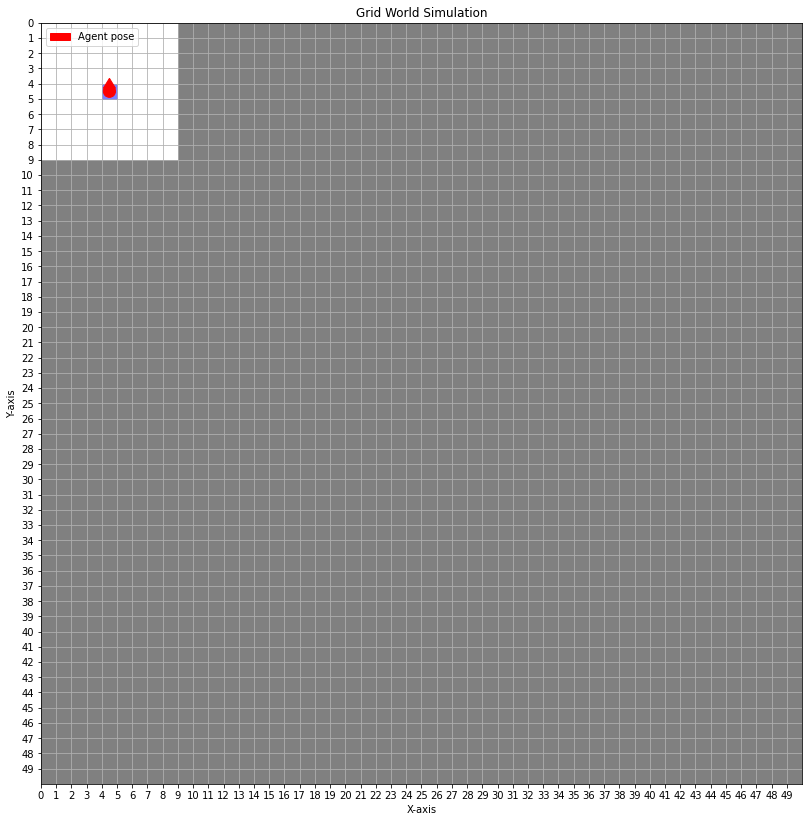

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Iteration 720
I

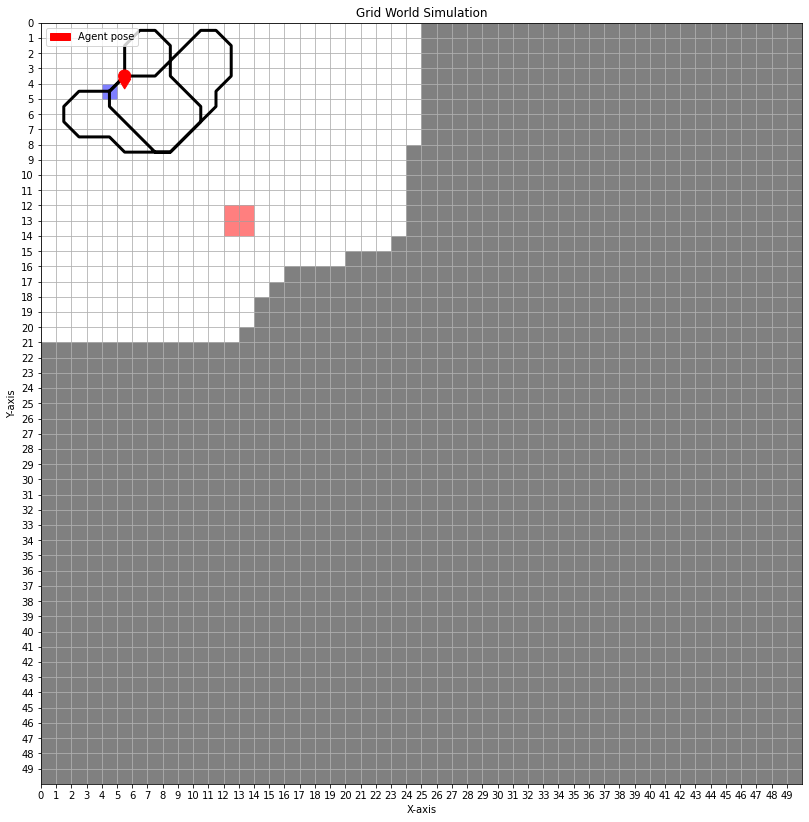

Iteration 1010
Iteration 1020
Iteration 1030
Iteration 1040
Iteration 1050
Iteration 1060
Iteration 1070
Iteration 1080
Iteration 1090
Iteration 1100
Iteration 1110
Iteration 1120
Iteration 1130
Iteration 1140
Iteration 1150
Iteration 1160
Iteration 1170
Iteration 1180
Iteration 1190
Iteration 1200
Iteration 1210
Iteration 1220
Iteration 1230
Iteration 1240
Iteration 1250
Iteration 1260
Iteration 1270
Iteration 1280
Iteration 1290
Iteration 1300
Iteration 1310
Iteration 1320
Iteration 1330
Iteration 1340
Iteration 1350
Iteration 1360
Iteration 1370
Iteration 1380
Iteration 1390
Iteration 1400
Iteration 1410
Iteration 1420
Iteration 1430
Iteration 1440
Iteration 1450
Iteration 1460
Iteration 1470
Iteration 1480
Iteration 1490
Iteration 1500
Iteration 1510
Iteration 1520
Iteration 1530
Iteration 1540
Iteration 1550
Iteration 1560
Iteration 1570
Iteration 1580
Iteration 1590
Iteration 1600
Iteration 1610
Iteration 1620
Iteration 1630
Iteration 1640
Iteration 1650
Iteration 1660
Iteration 

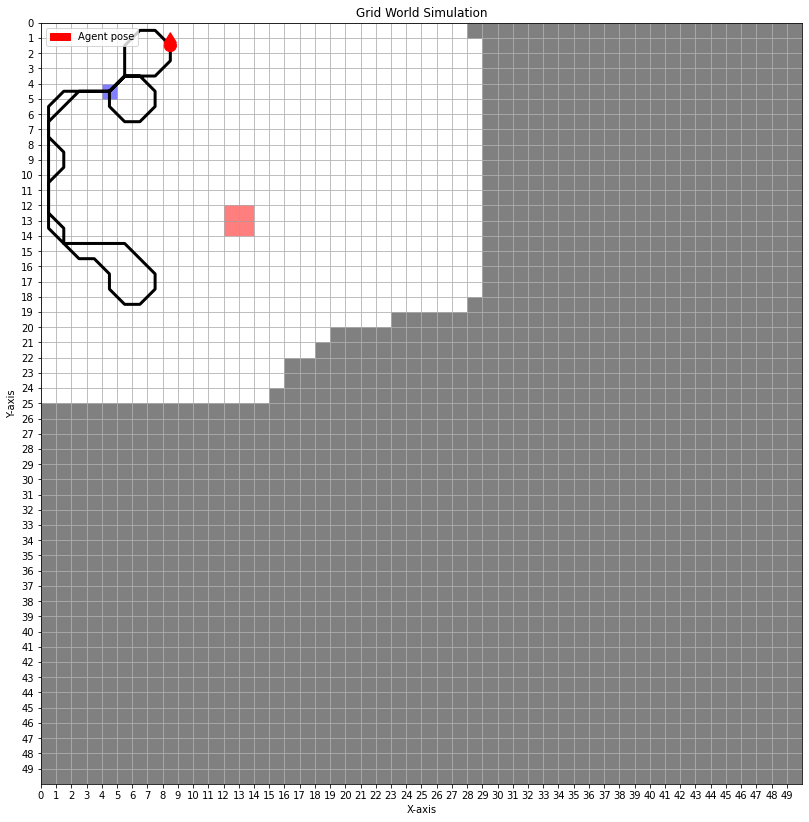

Iteration 2010
Iteration 2020
Iteration 2030
Iteration 2040
Iteration 2050
Iteration 2060
Iteration 2070
Iteration 2080
Iteration 2090
Iteration 2100
Iteration 2110
Iteration 2120
Iteration 2130
Iteration 2140
Iteration 2150
Iteration 2160
Iteration 2170
Iteration 2180
Iteration 2190
Iteration 2200
Iteration 2210
Iteration 2220
Iteration 2230
Iteration 2240
Iteration 2250
Iteration 2260
Iteration 2270
Iteration 2280
Iteration 2290
Iteration 2300
Iteration 2310
Iteration 2320
Iteration 2330
Iteration 2340
Iteration 2350
Iteration 2360
Iteration 2370
Iteration 2380
Iteration 2390
Iteration 2400
Iteration 2410
Iteration 2420
Iteration 2430
Iteration 2440
Iteration 2450
Iteration 2460
Iteration 2470
Iteration 2480
Iteration 2490
Iteration 2500
Iteration 2510
Iteration 2520
Iteration 2530
Iteration 2540
Iteration 2550
Iteration 2560
Iteration 2570
Iteration 2580
Iteration 2590
Iteration 2600
Iteration 2610
Iteration 2620
Iteration 2630
Iteration 2640
Iteration 2650
Iteration 2660
Iteration 

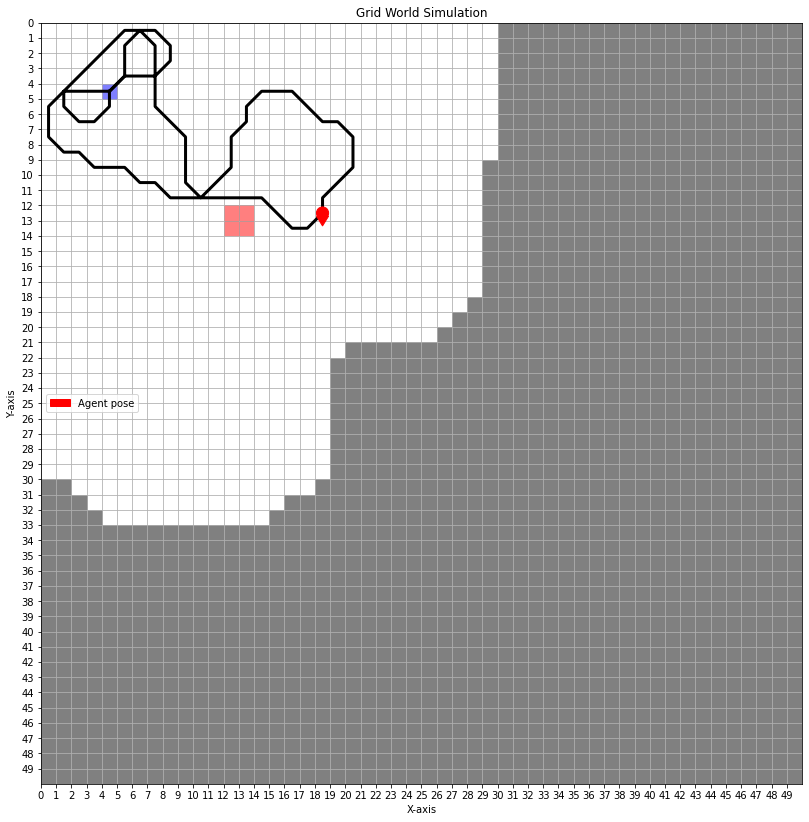

Iteration 3010
Iteration 3020
Iteration 3030
Iteration 3040
Iteration 3050
Iteration 3060
Iteration 3070
Iteration 3080
Iteration 3090
Iteration 3100
Iteration 3110
Iteration 3120
Iteration 3130
Iteration 3140
Iteration 3150
Iteration 3160
Iteration 3170
Iteration 3180
Iteration 3190
Iteration 3200
Iteration 3210
Iteration 3220
Iteration 3230
Iteration 3240
Iteration 3250
Iteration 3260
Iteration 3270
Iteration 3280
Iteration 3290
Iteration 3300
Iteration 3310
Iteration 3320
Iteration 3330
Iteration 3340
Iteration 3350
Iteration 3360
Iteration 3370
Iteration 3380
Iteration 3390
Iteration 3400
Iteration 3410
Iteration 3420
Iteration 3430
Iteration 3440
Iteration 3450
Iteration 3460
Iteration 3470
Iteration 3480
Iteration 3490
Iteration 3500
Iteration 3510
Iteration 3520
Iteration 3530
Iteration 3540
Iteration 3550
Iteration 3560
Iteration 3570
Iteration 3580
Iteration 3590
Iteration 3600
Iteration 3610
Iteration 3620
Iteration 3630
Iteration 3640
Iteration 3650
Iteration 3660
Iteration 

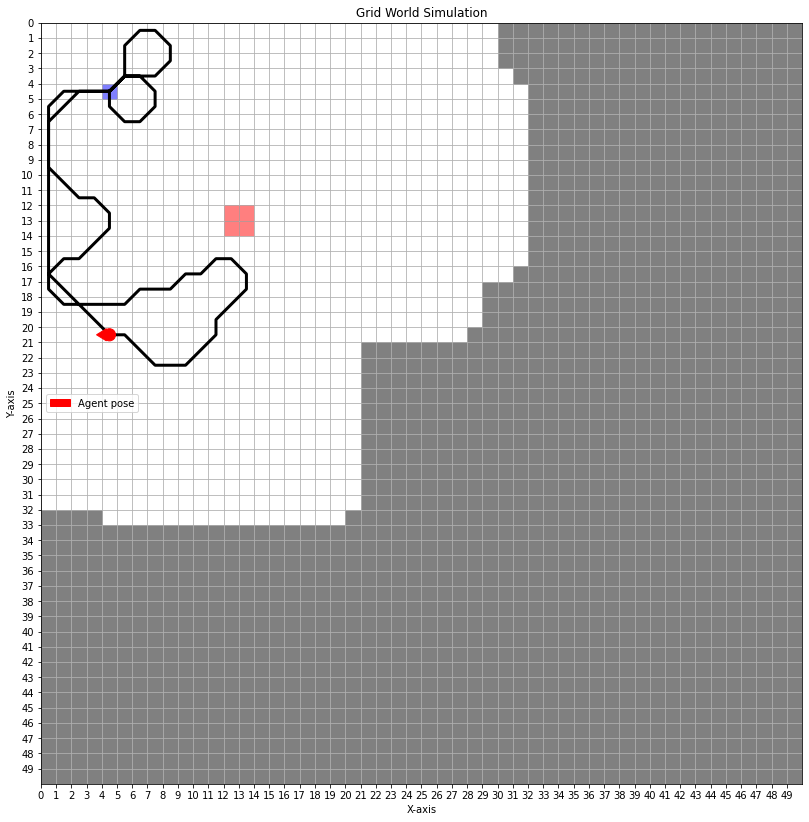

Iteration 4010
Iteration 4020
Iteration 4030
Iteration 4040
Iteration 4050
Iteration 4060
Iteration 4070
Iteration 4080
Iteration 4090
Iteration 4100
Iteration 4110
Iteration 4120
Iteration 4130
Iteration 4140
Iteration 4150
Iteration 4160
Iteration 4170
Iteration 4180
Iteration 4190
Iteration 4200
Iteration 4210
Iteration 4220
Iteration 4230
Iteration 4240
Iteration 4250
Iteration 4260
Iteration 4270
Iteration 4280
Iteration 4290
Iteration 4300
Iteration 4310
Iteration 4320
Iteration 4330
Iteration 4340
Iteration 4350
Iteration 4360
Iteration 4370
Iteration 4380
Iteration 4390
Iteration 4400
Iteration 4410
Iteration 4420
Iteration 4430
Iteration 4440
Iteration 4450
Iteration 4460
Iteration 4470
Iteration 4480
Iteration 4490
Iteration 4500
Iteration 4510
Iteration 4520
Iteration 4530
Iteration 4540
Iteration 4550
Iteration 4560
Iteration 4570
Iteration 4580
Iteration 4590
Iteration 4600
Iteration 4610
Iteration 4620
Iteration 4630
Iteration 4640
Iteration 4650
Iteration 4660
Iteration 

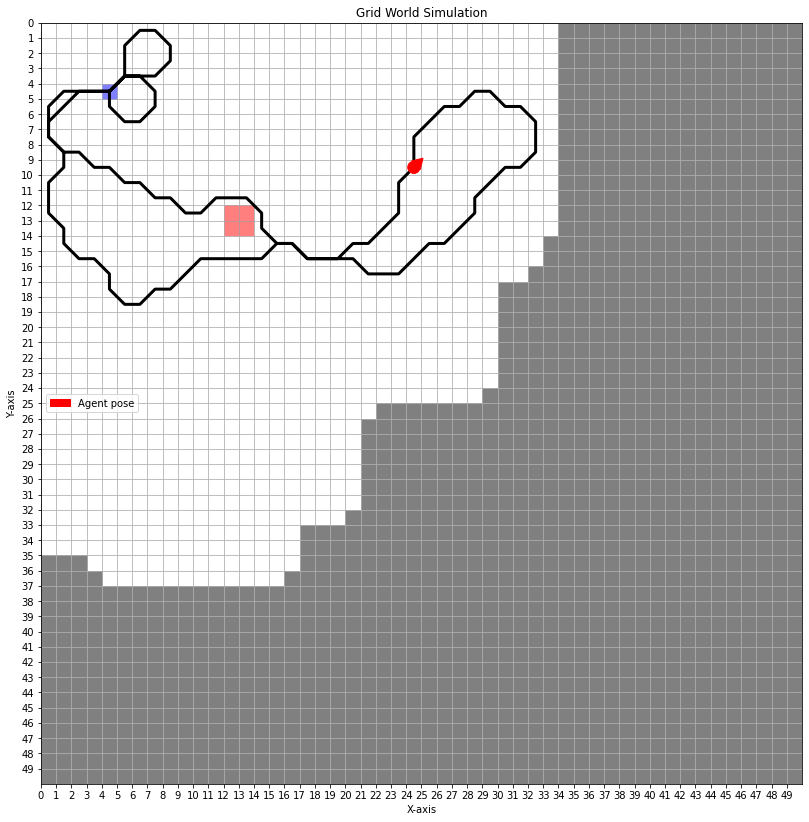

Iteration 5010
Iteration 5020
Iteration 5030
Iteration 5040
Iteration 5050
Iteration 5060
Iteration 5070
Iteration 5080
Iteration 5090
Iteration 5100
Iteration 5110
Iteration 5120
Iteration 5130
Iteration 5140
Iteration 5150
Iteration 5160
Iteration 5170
Iteration 5180
Iteration 5190
Iteration 5200
Iteration 5210
Iteration 5220
Iteration 5230
Iteration 5240
Iteration 5250
Iteration 5260
Iteration 5270
Iteration 5280
Iteration 5290
Iteration 5300
Iteration 5310
Iteration 5320
Iteration 5330
Iteration 5340
Iteration 5350
Iteration 5360
Iteration 5370
Iteration 5380
Iteration 5390
Iteration 5400
Iteration 5410
Iteration 5420
Iteration 5430
Iteration 5440
Iteration 5450
Iteration 5460
Iteration 5470
Iteration 5480
Iteration 5490
Iteration 5500
Iteration 5510
Iteration 5520
Iteration 5530
Iteration 5540
Iteration 5550
Iteration 5560
Iteration 5570
Iteration 5580
Iteration 5590
Iteration 5600
Iteration 5610
Iteration 5620
Iteration 5630
Iteration 5640
Iteration 5650
Iteration 5660
Iteration 

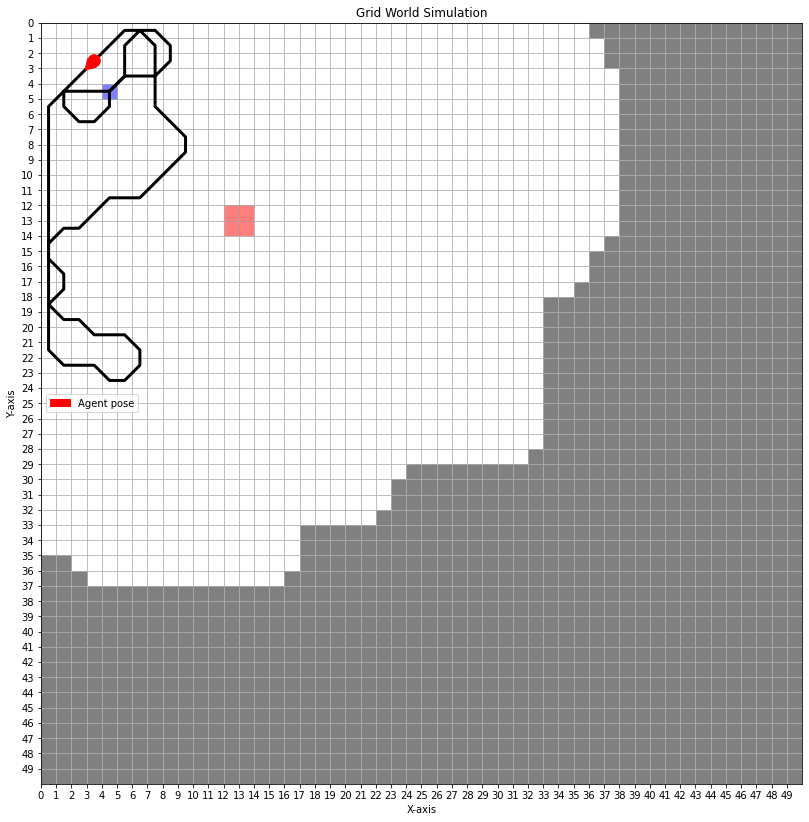

Iteration 6010
Iteration 6020
Iteration 6030
Iteration 6040
Iteration 6050
Iteration 6060
Iteration 6070
Iteration 6080
Iteration 6090
Iteration 6100
Iteration 6110
Iteration 6120
Iteration 6130
Iteration 6140
Iteration 6150
Iteration 6160
Iteration 6170
Iteration 6180
Iteration 6190
Iteration 6200
Iteration 6210
Iteration 6220
Iteration 6230
Iteration 6240
Iteration 6250
Iteration 6260
Iteration 6270
Iteration 6280
Iteration 6290
Iteration 6300
Iteration 6310
Iteration 6320
Iteration 6330
Iteration 6340
Iteration 6350
Iteration 6360
Iteration 6370
Iteration 6380
Iteration 6390
Iteration 6400
Iteration 6410
Iteration 6420
Iteration 6430
Iteration 6440
Iteration 6450
Iteration 6460
Iteration 6470
Iteration 6480
Iteration 6490
Iteration 6500
Iteration 6510
Iteration 6520
Iteration 6530
Iteration 6540
Iteration 6550
Iteration 6560
Iteration 6570
Iteration 6580
Iteration 6590
Iteration 6600
Iteration 6610
Iteration 6620
Iteration 6630
Iteration 6640
Iteration 6650
Iteration 6660
Iteration 

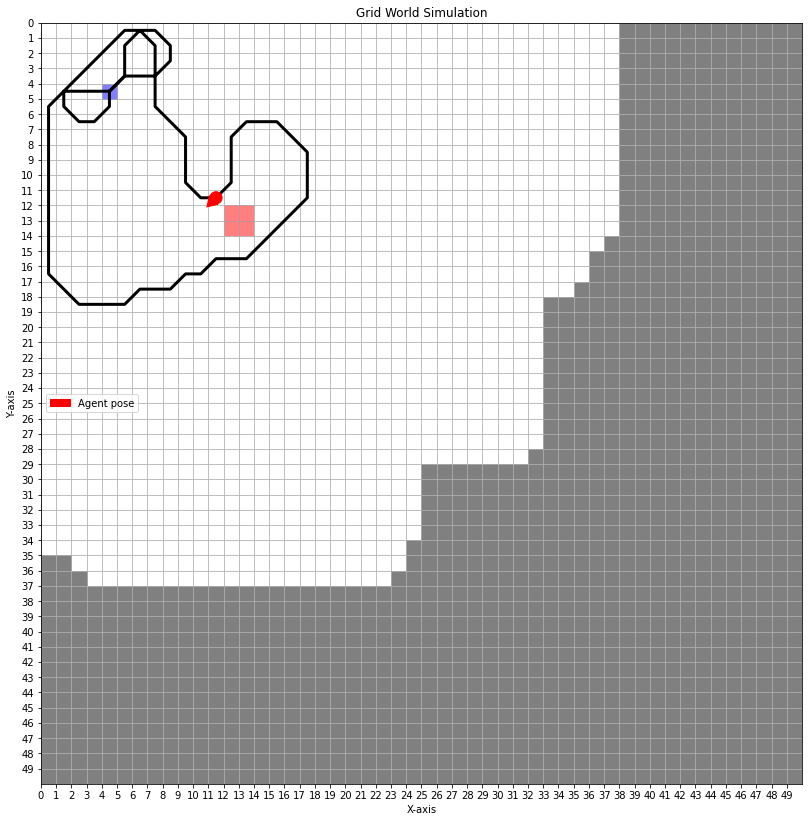

Iteration 7010
Iteration 7020
Iteration 7030
Iteration 7040
Iteration 7050
Iteration 7060
Iteration 7070
Iteration 7080
Iteration 7090
Iteration 7100
Iteration 7110
Iteration 7120
Iteration 7130
Iteration 7140
Iteration 7150
Iteration 7160
Iteration 7170
Iteration 7180
Iteration 7190
Iteration 7200
Iteration 7210
Iteration 7220
Iteration 7230
Iteration 7240
Iteration 7250
Iteration 7260
Iteration 7270
Iteration 7280
Iteration 7290
Iteration 7300
Iteration 7310
Iteration 7320
Iteration 7330
Iteration 7340
Iteration 7350
Iteration 7360
Iteration 7370
Iteration 7380
Iteration 7390
Iteration 7400
Iteration 7410
Iteration 7420
Iteration 7430
Iteration 7440
Iteration 7450
Iteration 7460
Iteration 7470
Iteration 7480
Iteration 7490
Iteration 7500
Iteration 7510
Iteration 7520
Iteration 7530
Iteration 7540
Iteration 7550
Iteration 7560
Iteration 7570
Iteration 7580
Iteration 7590
Iteration 7600
Iteration 7610
Iteration 7620
Iteration 7630
Iteration 7640
Iteration 7650
Iteration 7660
Iteration 

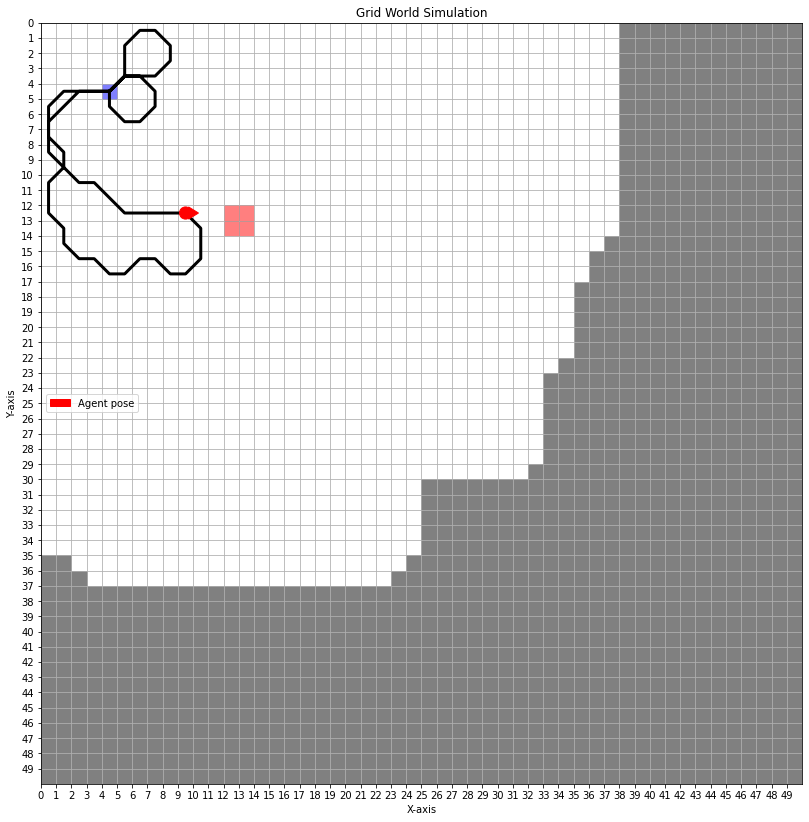

Iteration 8010
Iteration 8020
Iteration 8030
Iteration 8040
Iteration 8050
Iteration 8060
Iteration 8070
Iteration 8080
Iteration 8090
Iteration 8100
Iteration 8110
Iteration 8120
Iteration 8130
Iteration 8140
Iteration 8150
Iteration 8160
Iteration 8170
Iteration 8180
Iteration 8190
Iteration 8200
Iteration 8210
Iteration 8220
Iteration 8230
Iteration 8240
Iteration 8250
Iteration 8260
Iteration 8270
Iteration 8280
Iteration 8290
Iteration 8300
Iteration 8310
Iteration 8320
Iteration 8330
Iteration 8340
Iteration 8350
Iteration 8360
Iteration 8370
Iteration 8380
Iteration 8390
Iteration 8400
Iteration 8410
Iteration 8420
Iteration 8430
Iteration 8440
Iteration 8450
Iteration 8460
Iteration 8470
Iteration 8480
Iteration 8490
Iteration 8500
Iteration 8510
Iteration 8520
Iteration 8530
Iteration 8540
Iteration 8550
Iteration 8560
Iteration 8570
Iteration 8580
Iteration 8590
Iteration 8600
Iteration 8610
Iteration 8620
Iteration 8630
Iteration 8640
Iteration 8650
Iteration 8660
Iteration 

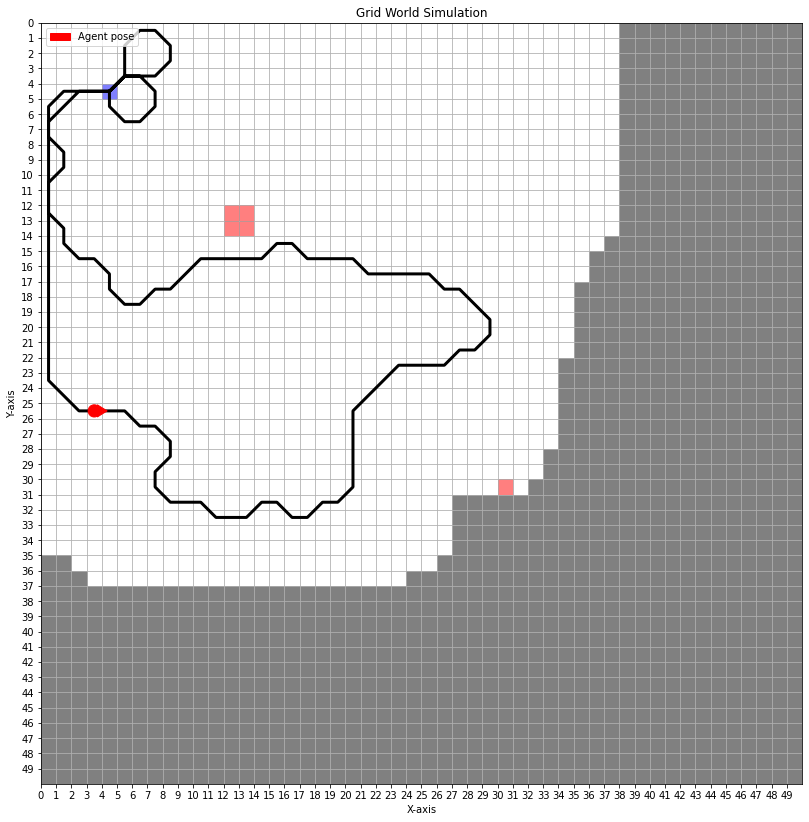

Iteration 9010
Iteration 9020
Iteration 9030
Iteration 9040
Iteration 9050
Iteration 9060
Iteration 9070
Iteration 9080
Iteration 9090
Iteration 9100
Iteration 9110
Iteration 9120
Iteration 9130
Iteration 9140
Iteration 9150
Iteration 9160
Iteration 9170
Iteration 9180
Iteration 9190
Iteration 9200
Iteration 9210
Iteration 9220
Iteration 9230
Iteration 9240
Iteration 9250
Iteration 9260
Iteration 9270
Iteration 9280
Iteration 9290
Iteration 9300
Iteration 9310
Iteration 9320
Iteration 9330
Iteration 9340
Iteration 9350
Iteration 9360
Iteration 9370
Iteration 9380
Iteration 9390
Iteration 9400
Iteration 9410
Iteration 9420
Iteration 9430
Iteration 9440
Iteration 9450
Iteration 9460
Iteration 9470
Iteration 9480
Iteration 9490
Iteration 9500
Iteration 9510
Iteration 9520
Iteration 9530
Iteration 9540
Iteration 9550
Iteration 9560
Iteration 9570
Iteration 9580
Iteration 9590
Iteration 9600
Iteration 9610
Iteration 9620
Iteration 9630
Iteration 9640
Iteration 9650
Iteration 9660
Iteration 

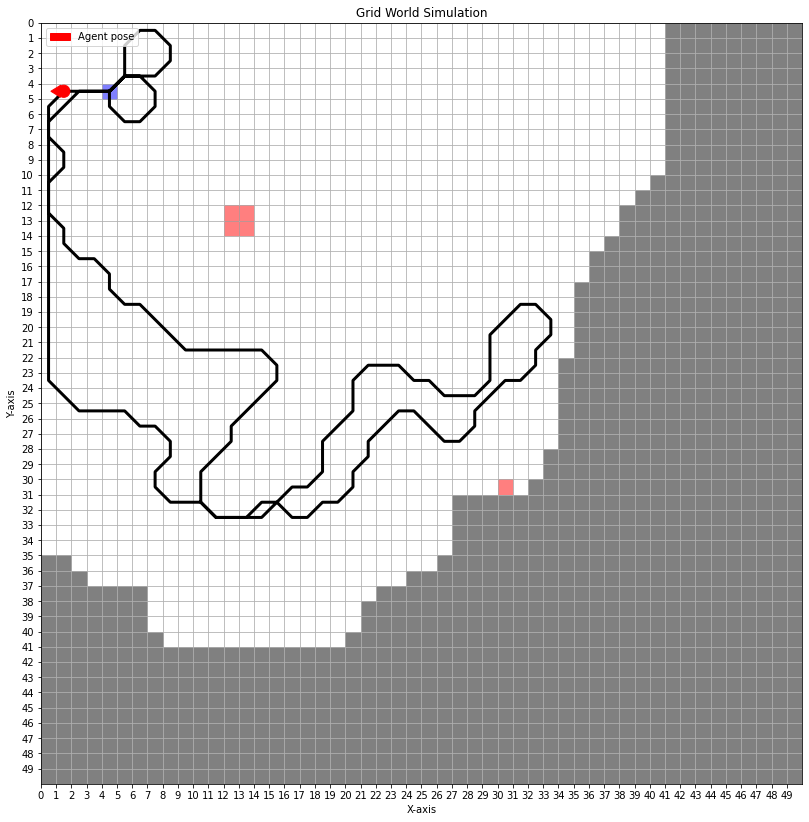

Iteration 10010
Iteration 10020
Iteration 10030
Iteration 10040
Iteration 10050
Iteration 10060
Iteration 10070
Iteration 10080
Iteration 10090
Iteration 10100
Iteration 10110
Iteration 10120
Iteration 10130
Iteration 10140
Iteration 10150
Iteration 10160
Iteration 10170
Iteration 10180
Iteration 10190
Iteration 10200
Iteration 10210
Iteration 10220
Iteration 10230
Iteration 10240
Iteration 10250
Iteration 10260
Iteration 10270
Iteration 10280
Iteration 10290
Iteration 10300
Iteration 10310
Iteration 10320
Iteration 10330
Iteration 10340
Iteration 10350
Iteration 10360
Iteration 10370
Iteration 10380
Iteration 10390
Iteration 10400
Iteration 10410
Iteration 10420
Iteration 10430
Iteration 10440
Iteration 10450
Iteration 10460
Iteration 10470
Iteration 10480
Iteration 10490
Iteration 10500
Iteration 10510
Iteration 10520
Iteration 10530
Iteration 10540
Iteration 10550
Iteration 10560
Iteration 10570
Iteration 10580
Iteration 10590
Iteration 10600
Iteration 10610
Iteration 10620
Iteratio

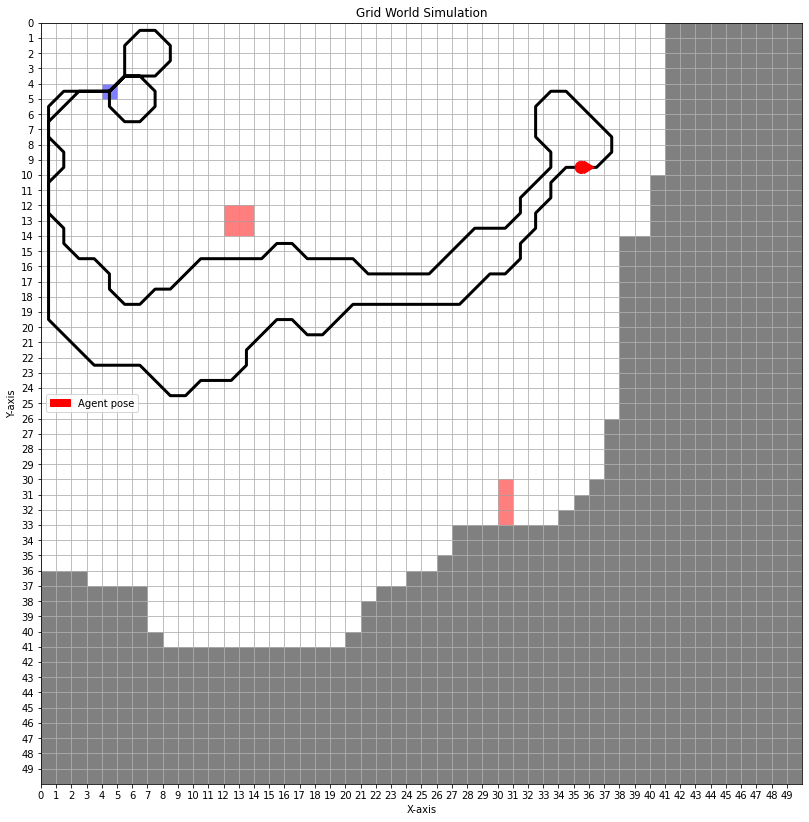

Iteration 11010
Iteration 11020
Iteration 11030
Iteration 11040
Iteration 11050
Iteration 11060
Iteration 11070
Iteration 11080
Iteration 11090
Iteration 11100
Iteration 11110
Iteration 11120
Iteration 11130
Iteration 11140
Iteration 11150
Iteration 11160
Iteration 11170
Iteration 11180
Iteration 11190
Iteration 11200
Iteration 11210
Iteration 11220
Iteration 11230
Iteration 11240
Iteration 11250
Iteration 11260
Iteration 11270
Iteration 11280
Iteration 11290
Iteration 11300
Iteration 11310
Iteration 11320
Iteration 11330
Iteration 11340
Iteration 11350
Iteration 11360
Iteration 11370
Iteration 11380
Iteration 11390
Iteration 11400
Iteration 11410
Iteration 11420
Iteration 11430
Iteration 11440
Iteration 11450
Iteration 11460
Iteration 11470
Iteration 11480
Iteration 11490
Iteration 11500
Iteration 11510
Iteration 11520
Iteration 11530
Iteration 11540
Iteration 11550
Iteration 11560
Iteration 11570
Iteration 11580
Iteration 11590
Iteration 11600
Iteration 11610
Iteration 11620
Iteratio

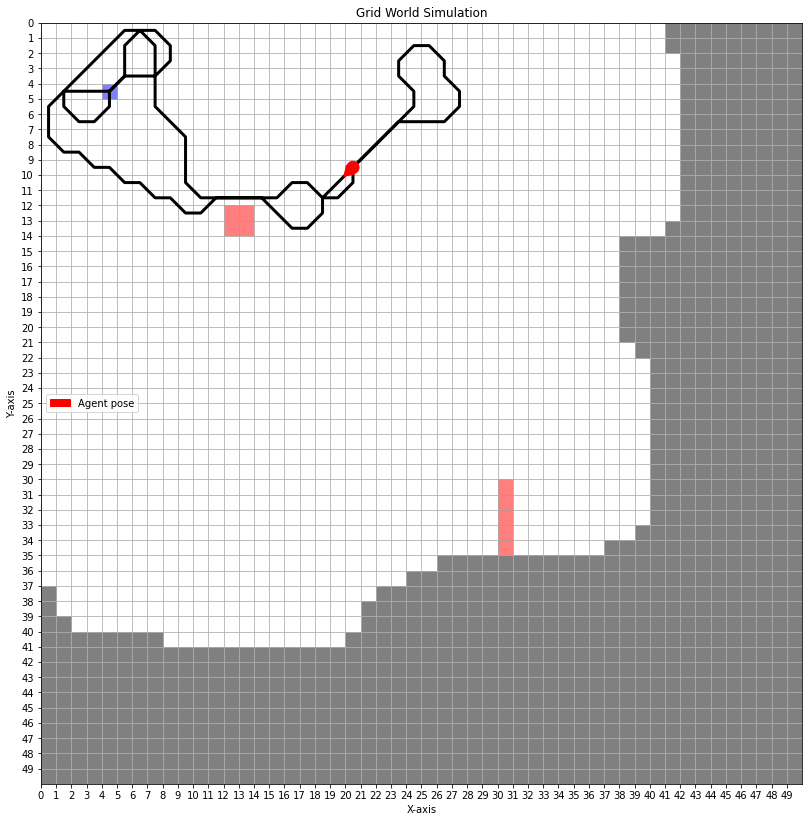

Iteration 12010
Iteration 12020
Iteration 12030
Iteration 12040
Iteration 12050
Iteration 12060
Iteration 12070
Iteration 12080
Iteration 12090
Iteration 12100
Iteration 12110
Iteration 12120
Iteration 12130
Iteration 12140
Iteration 12150
Iteration 12160
Iteration 12170
Iteration 12180
Iteration 12190
Iteration 12200
Iteration 12210
Iteration 12220
Iteration 12230
Iteration 12240
Iteration 12250
Iteration 12260
Iteration 12270
Iteration 12280
Iteration 12290
Iteration 12300
Iteration 12310
Iteration 12320
Iteration 12330
Iteration 12340
Iteration 12350
Iteration 12360
Iteration 12370
Iteration 12380
Iteration 12390
Iteration 12400
Iteration 12410
Iteration 12420
Iteration 12430
Iteration 12440
Iteration 12450
Iteration 12460
Iteration 12470
Iteration 12480
Iteration 12490
Iteration 12500
Iteration 12510
Iteration 12520
Iteration 12530
Iteration 12540
Iteration 12550
Iteration 12560
Iteration 12570
Iteration 12580
Iteration 12590
Iteration 12600
Iteration 12610
Iteration 12620
Iteratio

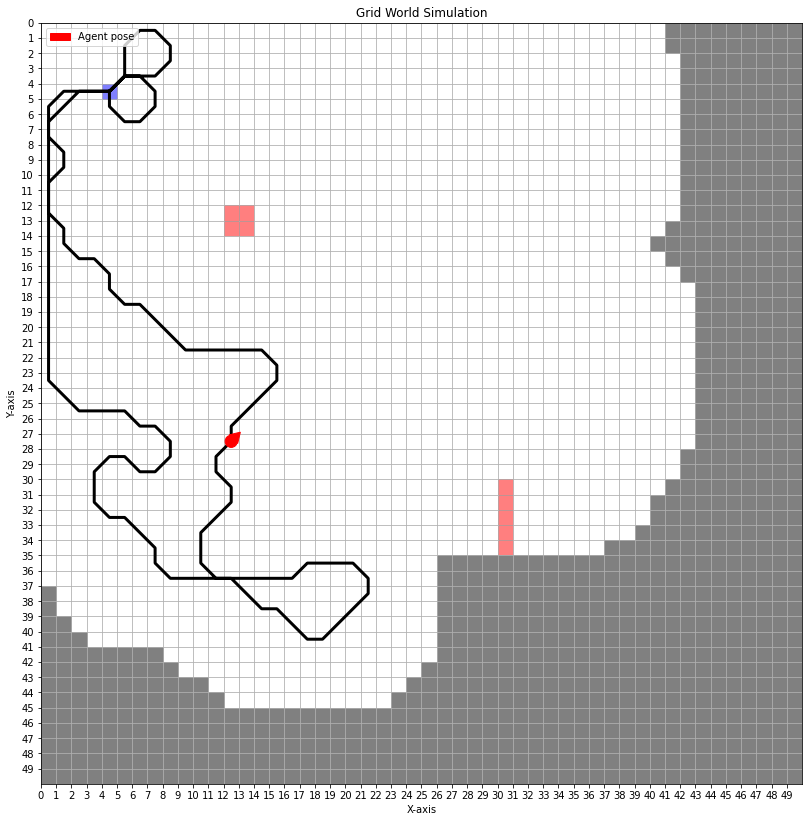

Iteration 13010
Iteration 13020
Iteration 13030
Iteration 13040
Iteration 13050
Iteration 13060
Iteration 13070
Iteration 13080
Iteration 13090
Iteration 13100
Iteration 13110
Iteration 13120
Iteration 13130
Iteration 13140
Iteration 13150
Iteration 13160
Iteration 13170
Iteration 13180
Iteration 13190
Iteration 13200
Iteration 13210
Iteration 13220
Iteration 13230
Iteration 13240
Iteration 13250
Iteration 13260
Iteration 13270
Iteration 13280
Iteration 13290
Iteration 13300
Iteration 13310
Iteration 13320
Iteration 13330
Iteration 13340
Iteration 13350
Iteration 13360
Iteration 13370
Iteration 13380
Iteration 13390
Iteration 13400
Iteration 13410
Iteration 13420
Iteration 13430
Iteration 13440
Iteration 13450
Iteration 13460
Iteration 13470
Iteration 13480
Iteration 13490
Iteration 13500
Iteration 13510
Iteration 13520
Iteration 13530
Iteration 13540
Iteration 13550
Iteration 13560
Iteration 13570
Iteration 13580
Iteration 13590
Iteration 13600
Iteration 13610
Iteration 13620
Iteratio

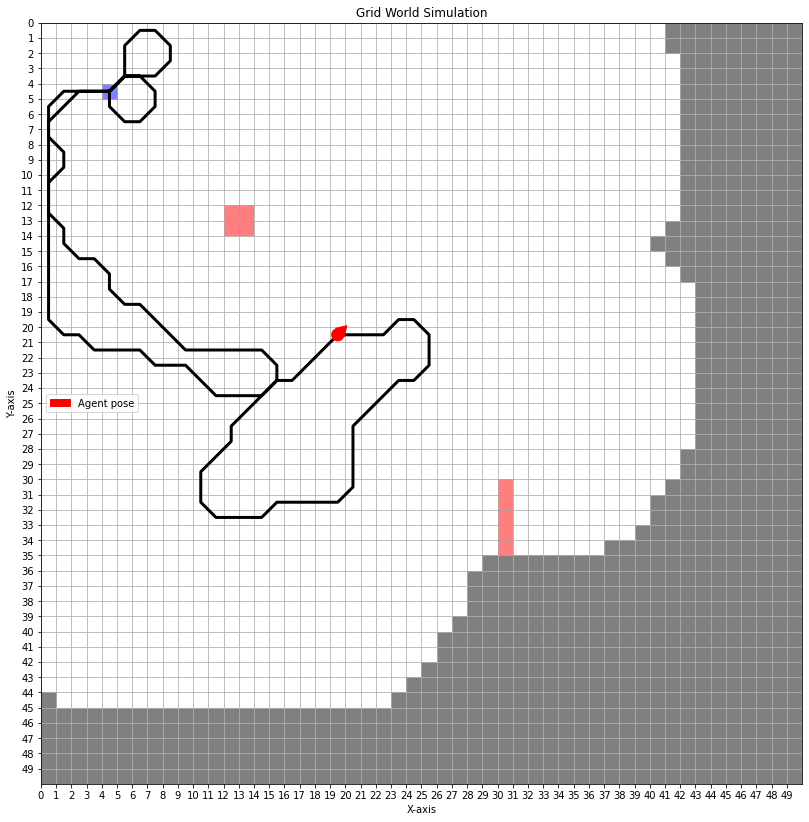

Iteration 14010
Iteration 14020
Iteration 14030
Iteration 14040
Iteration 14050
Iteration 14060
Iteration 14070
Iteration 14080
Iteration 14090
Iteration 14100
Iteration 14110
Iteration 14120
Iteration 14130
Iteration 14140
Iteration 14150
Iteration 14160
Iteration 14170
Iteration 14180
Iteration 14190
Iteration 14200
Iteration 14210
Iteration 14220
Iteration 14230
Iteration 14240
Iteration 14250
Iteration 14260
Iteration 14270
Iteration 14280
Iteration 14290
Iteration 14300
Iteration 14310
Iteration 14320
Iteration 14330
Iteration 14340
Iteration 14350
Iteration 14360
Iteration 14370
Iteration 14380
Iteration 14390
Iteration 14400
Iteration 14410
Iteration 14420
Iteration 14430
Iteration 14440
Iteration 14450
Iteration 14460
Iteration 14470
Iteration 14480
Iteration 14490
Iteration 14500
Iteration 14510
Iteration 14520
Iteration 14530
Iteration 14540
Iteration 14550
Iteration 14560
Iteration 14570
Iteration 14580
Iteration 14590
Iteration 14600
Iteration 14610
Iteration 14620
Iteratio

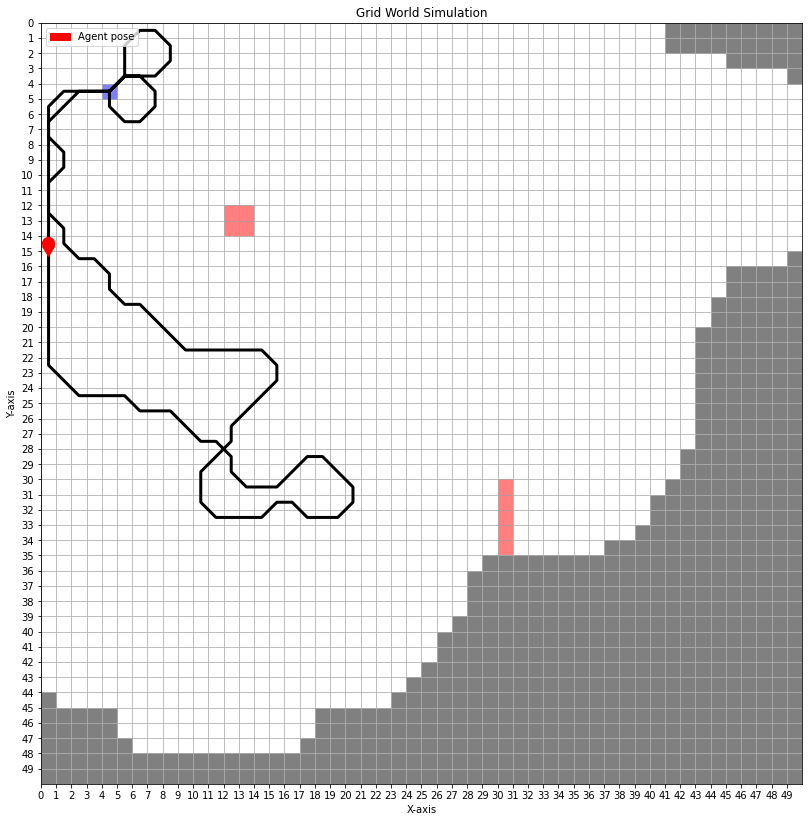

Iteration 15010
Iteration 15020
Iteration 15030
Iteration 15040
Iteration 15050
Iteration 15060
Iteration 15070
Iteration 15080
Iteration 15090
Iteration 15100
Iteration 15110
Iteration 15120
Iteration 15130
Iteration 15140
Iteration 15150
Iteration 15160
Iteration 15170
Iteration 15180
Iteration 15190
Iteration 15200
Iteration 15210
Iteration 15220
Iteration 15230
Iteration 15240
Iteration 15250
Iteration 15260
Iteration 15270
Iteration 15280
Iteration 15290
Iteration 15300
Iteration 15310
Iteration 15320
Iteration 15330
Iteration 15340
Iteration 15350
Iteration 15360
Iteration 15370
Iteration 15380
Iteration 15390
Iteration 15400
Iteration 15410
Iteration 15420
Iteration 15430
Iteration 15440
Iteration 15450
Iteration 15460
Iteration 15470
Iteration 15480
Iteration 15490
Iteration 15500
Iteration 15510
Iteration 15520
Iteration 15530
Iteration 15540
Iteration 15550
Iteration 15560
Iteration 15570
Iteration 15580
Iteration 15590
Iteration 15600
Iteration 15610
Iteration 15620
Iteratio

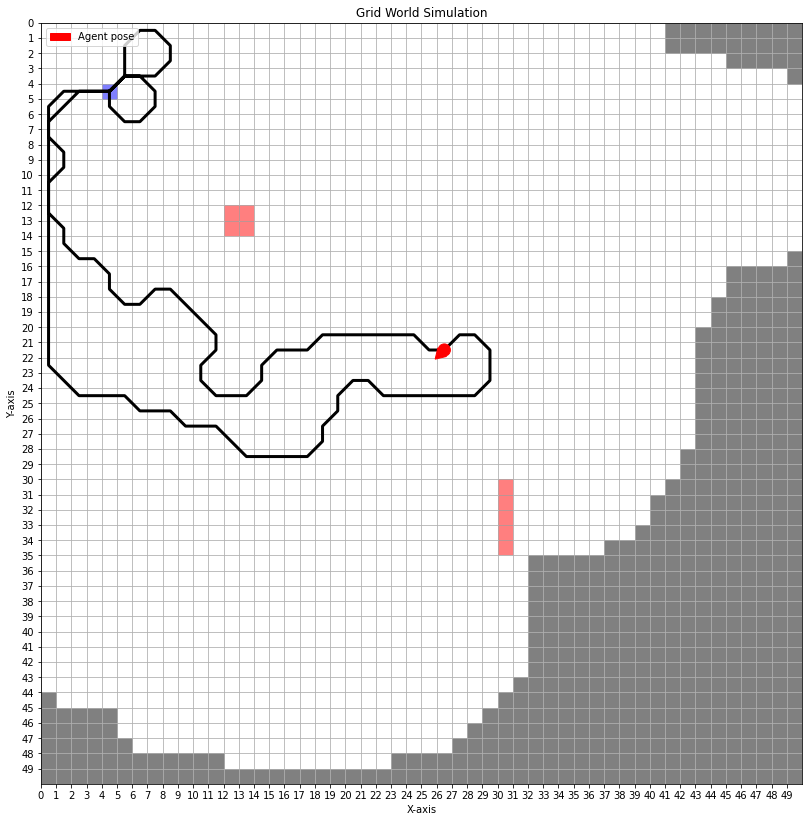

Iteration 16010
Iteration 16020
Iteration 16030
Iteration 16040
Iteration 16050
Iteration 16060
Iteration 16070
Iteration 16080
Iteration 16090
Iteration 16100
Iteration 16110
Iteration 16120
Iteration 16130
Iteration 16140
Iteration 16150
Iteration 16160
Iteration 16170
Iteration 16180
Iteration 16190
Iteration 16200
Iteration 16210
Iteration 16220
Iteration 16230
Iteration 16240
Iteration 16250
Iteration 16260
Iteration 16270
Iteration 16280
Iteration 16290
Iteration 16300
Iteration 16310
Iteration 16320
Iteration 16330
Iteration 16340
Iteration 16350
Iteration 16360
Iteration 16370
Iteration 16380
Iteration 16390
Iteration 16400
Iteration 16410
Iteration 16420
Iteration 16430
Iteration 16440
Iteration 16450
Iteration 16460
Iteration 16470
Iteration 16480
Iteration 16490
Iteration 16500
Iteration 16510
Iteration 16520
Iteration 16530
Iteration 16540
Iteration 16550
Iteration 16560
Iteration 16570
Iteration 16580
Iteration 16590
Iteration 16600
Iteration 16610
Iteration 16620
Iteratio

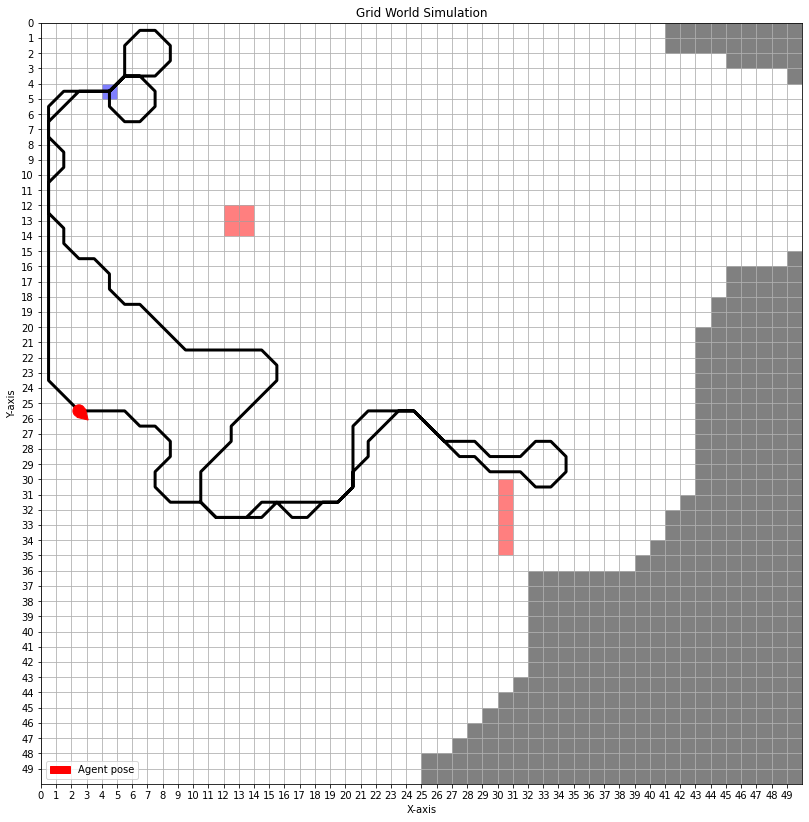

Iteration 17010
Iteration 17020
Iteration 17030
Iteration 17040
Iteration 17050
Iteration 17060
Iteration 17070
Iteration 17080
Iteration 17090
Iteration 17100
Iteration 17110
Iteration 17120
Iteration 17130
Iteration 17140
Iteration 17150
Iteration 17160
Iteration 17170
Iteration 17180
Iteration 17190
Iteration 17200
Iteration 17210
Iteration 17220
Iteration 17230
Iteration 17240
Iteration 17250
Iteration 17260
Iteration 17270
Iteration 17280
Iteration 17290
Iteration 17300
Iteration 17310
Iteration 17320
Iteration 17330
Iteration 17340
Iteration 17350
Iteration 17360
Iteration 17370
Iteration 17380
Iteration 17390
Iteration 17400
Iteration 17410
Iteration 17420
Iteration 17430
Iteration 17440
Iteration 17450
Iteration 17460
Iteration 17470
Iteration 17480
Iteration 17490
Iteration 17500
Iteration 17510
Iteration 17520
Iteration 17530
Iteration 17540
Iteration 17550
Iteration 17560
Iteration 17570
Iteration 17580
Iteration 17590
Iteration 17600
Iteration 17610
Iteration 17620
Iteratio

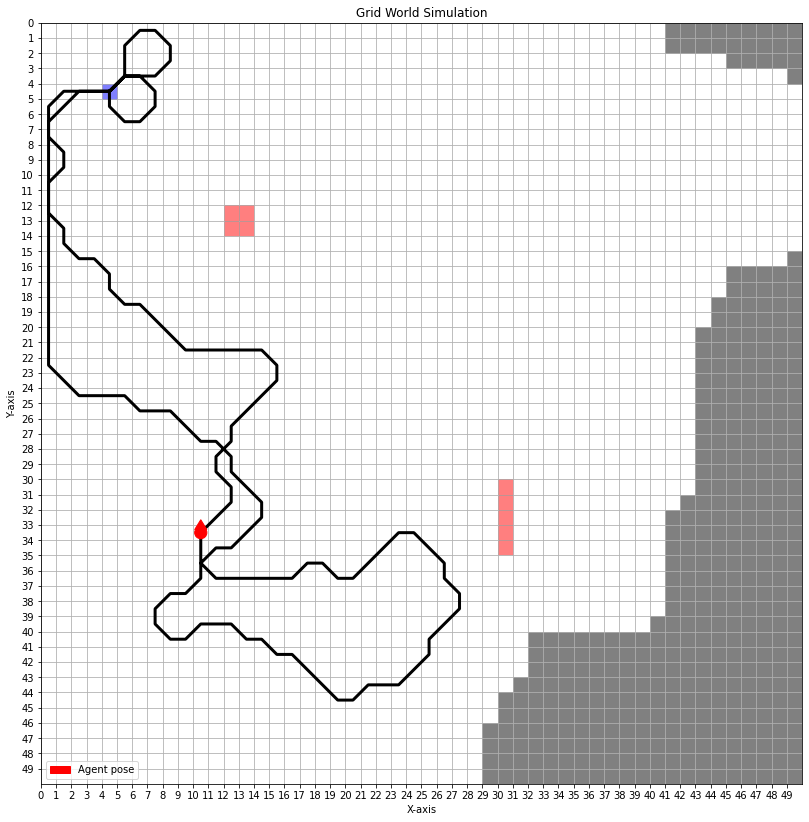

Iteration 18010
Iteration 18020
Iteration 18030
Iteration 18040
Iteration 18050
Iteration 18060
Iteration 18070
Iteration 18080
Iteration 18090
Iteration 18100
Iteration 18110
Iteration 18120
Iteration 18130
Iteration 18140
Iteration 18150
Iteration 18160
Iteration 18170
Iteration 18180
Iteration 18190
Iteration 18200
Iteration 18210
Iteration 18220
Iteration 18230
Iteration 18240
Iteration 18250
Iteration 18260
Iteration 18270
Iteration 18280
Iteration 18290
Iteration 18300
Iteration 18310
Iteration 18320
Iteration 18330
Iteration 18340
Iteration 18350
Iteration 18360
Iteration 18370
Iteration 18380
Iteration 18390
Iteration 18400
Iteration 18410
Iteration 18420
Iteration 18430
Iteration 18440
Iteration 18450
Iteration 18460
Iteration 18470
Iteration 18480
Iteration 18490
Iteration 18500
Iteration 18510
Iteration 18520
Iteration 18530
Iteration 18540
Iteration 18550
Iteration 18560
Iteration 18570
Iteration 18580
Iteration 18590
Iteration 18600
Iteration 18610
Iteration 18620
Iteratio

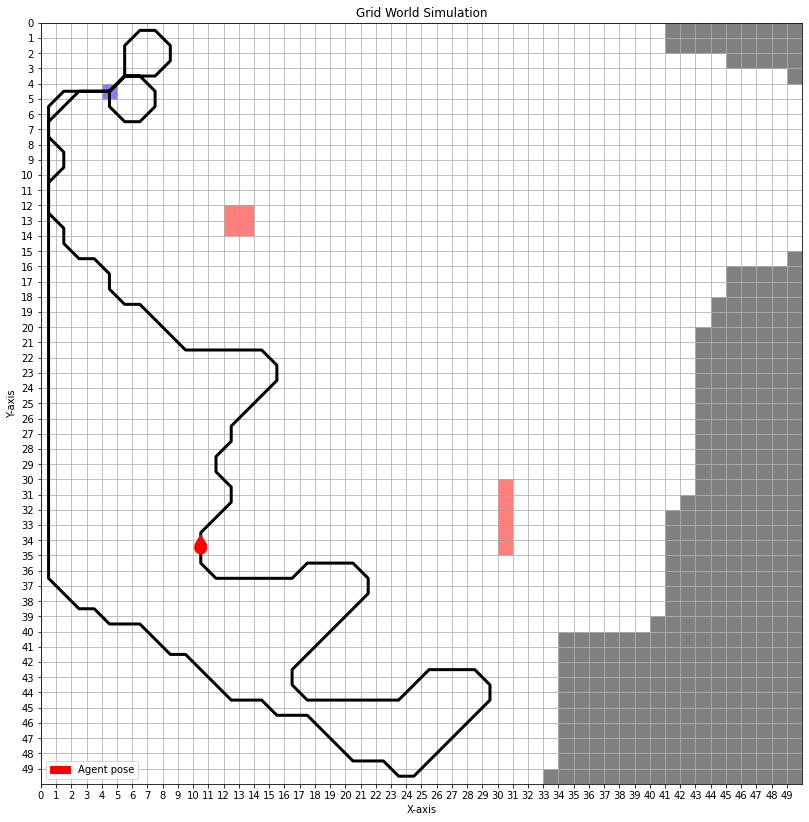

Iteration 19010
Iteration 19020
Iteration 19030
Iteration 19040
Iteration 19050
Iteration 19060
Iteration 19070
Iteration 19080
Iteration 19090
Iteration 19100
Iteration 19110
Iteration 19120
Iteration 19130
Iteration 19140
Iteration 19150
Iteration 19160
Iteration 19170
Iteration 19180
Iteration 19190
Iteration 19200
Iteration 19210
Iteration 19220
Iteration 19230
Iteration 19240
Iteration 19250
Iteration 19260
Iteration 19270
Iteration 19280
Iteration 19290
Iteration 19300
Iteration 19310
Iteration 19320
Iteration 19330
Iteration 19340
Iteration 19350
Iteration 19360
Iteration 19370
Iteration 19380
Iteration 19390
Iteration 19400
Iteration 19410
Iteration 19420
Iteration 19430
Iteration 19440
Iteration 19450
Iteration 19460
Iteration 19470
Iteration 19480
Iteration 19490
Iteration 19500
Iteration 19510
Iteration 19520
Iteration 19530
Iteration 19540
Iteration 19550
Iteration 19560
Iteration 19570
Iteration 19580
Iteration 19590
Iteration 19600
Iteration 19610
Iteration 19620
Iteratio

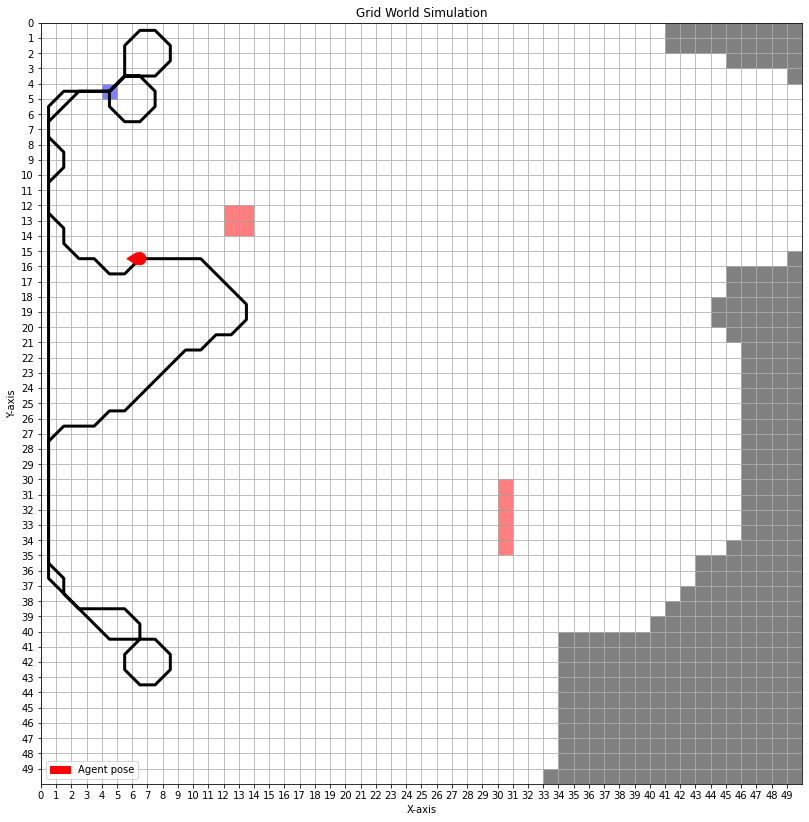

In [97]:
# SIMULATION
grid_height = 50
grid_width = 50
grid_2d = np.zeros((grid_height, grid_width))

# obstacles
# grid_2d[12:14, 12:14] = 1
obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
for obstacle in obstacles:
    grid_2d[obstacle[1], obstacle[0]] = 1

start_tyx = (0, 4, 4)
goal_tyx = (1,40,40)
grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# MEDIUM simulation
# grid_height = 25
# grid_width = 25
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (1,20,20)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# SMALL simulation
# grid_height = 12
# grid_width = 12
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# # grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (3,11,11)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
for i in range(grid_height):
    for j in range(grid_width):
        for k in range(8):
            world_table[k, i, j] = Node(k, i, j)

home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
home.in_gf = True
home.in_gb = True
goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
goal.in_gb = True


agent = Agent(home, goal, world_table)



iteration = 0
max_iterations = 20000
while iteration < max_iterations:
    if iteration % 10 == 0:
        print(f'Iteration {iteration}')
        # print(f'Visible: \n{str(agent.visible_positions)}')
        # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
        # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
        # print(f'agent_trajectory: \n{agent.trajectory}')

    if iteration % 1000 == 0:
        agent.plot_iteration()

    # sample a point to add to GF
    for _ in range(20):
        # success = False
        # while not success:
        coord = agent.sample_for_gf()
        # coord = (0, 8, 10)
        if coord is not None:
            success = agent.attempt_add_node_to_gf(coord)

    # sample a point to add to GB
    i = 0
    while i < 20 or len(agent.unvisited_gb) <= 0:
        i += 1
        coord, index = agent.sample_for_gb()
        if coord is None:
            continue
        success = agent.attempt_add_node_to_gb(coord, index)
        # if success: print(f'Added to GB: {coord}')

    if not agent.move(grid_2d):
        print(f'Failed to move, iteration: {iteration}')
        break

    # assert agent.pose not in obstacles, 'Agent ran into obstacle :('
    if agent.pose in obstacles:
        print(f'Agent ran into obstacle, iteration: {iteration}')
        print(f'Pose: {agent.pose}')
        agent.plot_iteration()
        break



    if agent.pose == (goal.x, goal.y):
        print(f'Goal reached, iteration: {iteration}')
        print(f'agent_trajectory: \n{agent.trajectory}')
        break

    iteration += 1
    # time.sleep(0.01)
if iteration == max_iterations:
    print('Max iterations reached :(')
print(f'DONE: Iteration: {iteration}')
agent.plot_iteration()


In [100]:


# Receding horizon agent class
class AgentRH(Agent):
    def __init__(self, home: Node, goal: Node, world_table: NDArray, alpha: float=0.9):
        super().__init__(home, goal, world_table)

        self.theta = self.home.theta

        # check if it is possible to do receding horizon
        self.receding_horizon_possible = False
        if self.compute_safe_turnaround(get_reverse_state(home, self.world_table)) is not None:
            self.receding_horizon_possible = True

        self.in_receding_horizon_mode = False
        self.receding_horizon_trajectory = []
        self.alpha = alpha

    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # takes a receding horizon trajectory with probability alpha, if it exists
    # returns true if successful, false if not
    def move(self, this_grid=grid_2d):
        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # transition to receding horizon mode when we are at least 1/3 through a 
        # trajectory, if possible
        # TODO: right now this is going to result in a lot of receding horizon
        # (i.e. even on the way back to the home state), but it will do for now
        if self.trajectory_index <= len(self.trajectory) // 3:
            self.in_receding_horizon_mode = self.receding_horizon_possible

        # if in receding horizon mode, try to take a receding horizon trajectory
        # accept as the new trajectory with probability alpha
        if self.in_receding_horizon_mode:
            success = self.compute_receding_horizon_trajectory()
            if success and rand.random() < self.alpha:
                self.trajectory = self.receding_horizon_trajectory
                self.trajectory_index = 0
                self.trajectory_complete = False
                self.in_receding_horizon_mode = True
                # print('Took receding horizon trajectory')
            else:
                self.in_receding_horizon_mode = False
                # print('Did not take receding horizon trajectory')


        # move to next position in trajectory
        self.trajectory_index += 1
        next_pose = self.trajectory[self.trajectory_index]
        self.theta = get_theta_from_poses(self.pose,  next_pose)
        self.pose = next_pose
        self.compute_sensor_update(this_grid)

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Attempt to compute a receding horizon trajectory
    # returns true if successful, false if not
    def compute_receding_horizon_trajectory(self):
        if not self.receding_horizon_possible:
            return False
        # uniformly get one of the three potential next states based on theta
        potential_next_states = get_potential_next_states(self.pose, self.theta)
        # shuffle
        rand.shuffle(potential_next_states)
        for state in potential_next_states:
            # make sure in the map
            if (state[0] < 0 or state[0] >= grid_width
                or state[1] < 0 or state[1] >= grid_height):
                continue
            # try to compute a safe turnaround
            next_theta = get_theta_from_poses(self.pose, state)
            safe_turnaround = self.compute_safe_turnaround(self.world_table[next_theta, state[1], state[0]])
            if safe_turnaround is None:
                continue

            # if successful, set receding horizon trajectory appropriately
            receding_horizon_trajectory = self.compute_receding_horizon_trajectory_pose_list(safe_turnaround)
            if receding_horizon_trajectory is None:
                continue
            self.receding_horizon_trajectory = receding_horizon_trajectory

            # return true
            return True
        # if no safe turnaround found, return false
        return False

    # Compute the safe turnaround procedure from state to the reverse of state
    # returns a list of tuples (x, y) that is the safe turnaround procedure, or
    # None if no such procedure exists or the procedure is not safe
    def compute_safe_turnaround(self, state: Node) -> List[Tuple[int, int]]:
        pose_list = []
        x = state.x
        y = state.y
        pose_list.append((x, y))
        # brute force depending on theta
        if state.theta == 0:
            pose_list.append((x-1, y-1))
            pose_list.append((x-2, y-2))
            pose_list.append((x-2, y-3))
            pose_list.append((x-1, y-4))
            pose_list.append((x, y-4))
            pose_list.append((x+1, y-3))
            pose_list.append((x+1, y-2))
            pose_list.append((x, y-1))
        elif state.theta == 1:
            pose_list.append((x+1, y-1))
            pose_list.append((x+1, y-2))
            pose_list.append((x+1, y-3))
            pose_list.append((x+2, y-4))
            pose_list.append((x+3, y-4))
            pose_list.append((x+4, y-3))
            pose_list.append((x+4, y-2))
            pose_list.append((x+3, y-1))
            pose_list.append((x+2, y-1))
            pose_list.append((x+1, y-1))
        elif state.theta == 2:
            pose_list.append((x+1, y-1))
            pose_list.append((x+2, y-2))
            pose_list.append((x+3, y-2))
            pose_list.append((x+4, y-1))
            pose_list.append((x+4, y))
            pose_list.append((x+3, y-1))
            pose_list.append((x+2, y-1))
            pose_list.append((x+1, y))
        elif state.theta == 3:
            pose_list.append((x+1, y+1))
            pose_list.append((x+2, y+1))
            pose_list.append((x+3, y+1))
            pose_list.append((x+4, y+2))
            pose_list.append((x+4, y+3))
            pose_list.append((x+3, y+4))
            pose_list.append((x+2, y+4))
            pose_list.append((x+1, y+3))
            pose_list.append((x+1, y+2))
            pose_list.append((x+1, y+1))
        elif state.theta == 4:
            pose_list.append((x+1, y+1))
            pose_list.append((x+2, y+2))
            pose_list.append((x+2, y+3))
            pose_list.append((x+1, y+4))
            pose_list.append((x, y+4))
            pose_list.append((x-1, y+3))
            pose_list.append((x-1, y+2))
            pose_list.append((x, y+1))
        elif state.theta == 5:
            pose_list.append((x-1, y+1))
            pose_list.append((x-1, y+2))
            pose_list.append((x-1, y+3))
            pose_list.append((x-2, y+4))
            pose_list.append((x-3, y+4))
            pose_list.append((x-4, y+3))
            pose_list.append((x-4, y+2))
            pose_list.append((x-3, y+1))
            pose_list.append((x-2, y+1))
            pose_list.append((x-1, y+1))
        elif state.theta == 6:
            pose_list.append((x-1, y+1))
            pose_list.append((x-2, y+2))
            pose_list.append((x-3, y+2))
            pose_list.append((x-4, y+1))
            pose_list.append((x-4, y))
            pose_list.append((x-3, y+1))
            pose_list.append((x-2, y+1))
            pose_list.append((x-1, y))
        elif state.theta == 7:
            pose_list.append((x-1, y-1))
            pose_list.append((x-2, y-1))
            pose_list.append((x-3, y-1))
            pose_list.append((x-4, y-2))
            pose_list.append((x-4, y-3))
            pose_list.append((x-3, y-4))
            pose_list.append((x-2, y-4))
            pose_list.append((x-1, y-3))
            pose_list.append((x-1, y-2))
            pose_list.append((x-1, y-1))
        pose_list.append((x, y))

        # check if the path is safe
        for pose in pose_list:
            if pose[0] < 0 or pose[0] >= grid_width or pose[1] < 0 or pose[1] >= grid_height:
                return None
            if grid_2d[pose[1], pose[0]] != 0:
                return None
        return pose_list


    def compute_receding_horizon_trajectory_pose_list(self,
                                            safe_turnaround: List[Tuple[int, int]]
                                            ) -> List[Tuple[int, int]]:
        pose_list = []
        pose_list.extend(safe_turnaround)
        # add the current trajectory up to this point in reverse (not including home)
        for i in range(self.trajectory_index, 0, -1):
            pose_list.append(self.trajectory[i])
        
        # add the safe turnaround from the reverse home state to the home state
        reverse_home = get_reverse_state(self.home)
        safe_turnaround = self.compute_safe_turnaround(reverse_home)
        pose_list.extend(safe_turnaround)

        return pose_list

Iteration 0


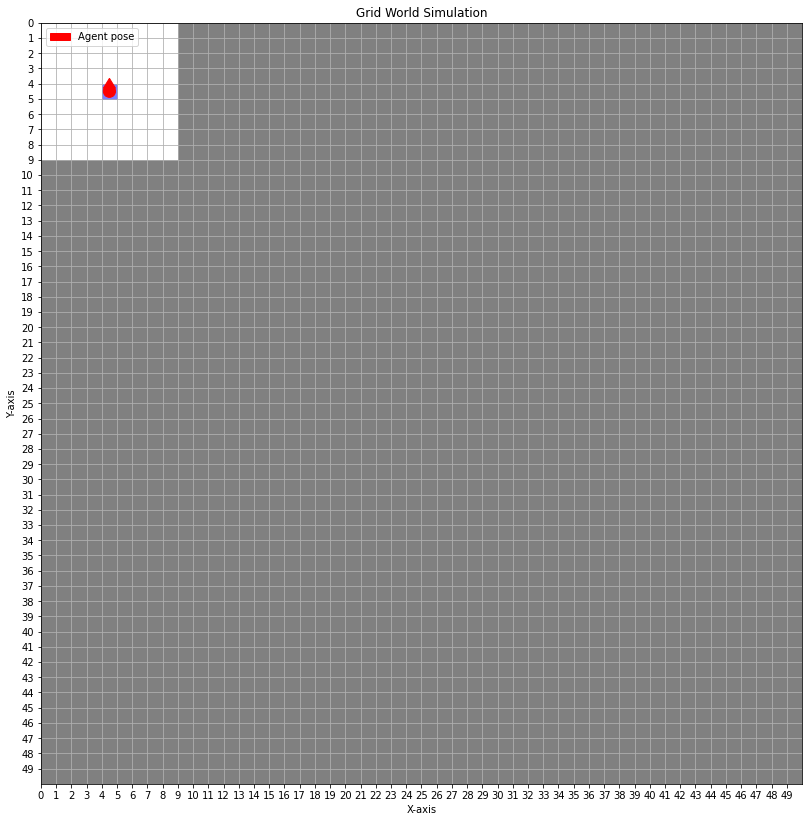

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Iteration 720
I

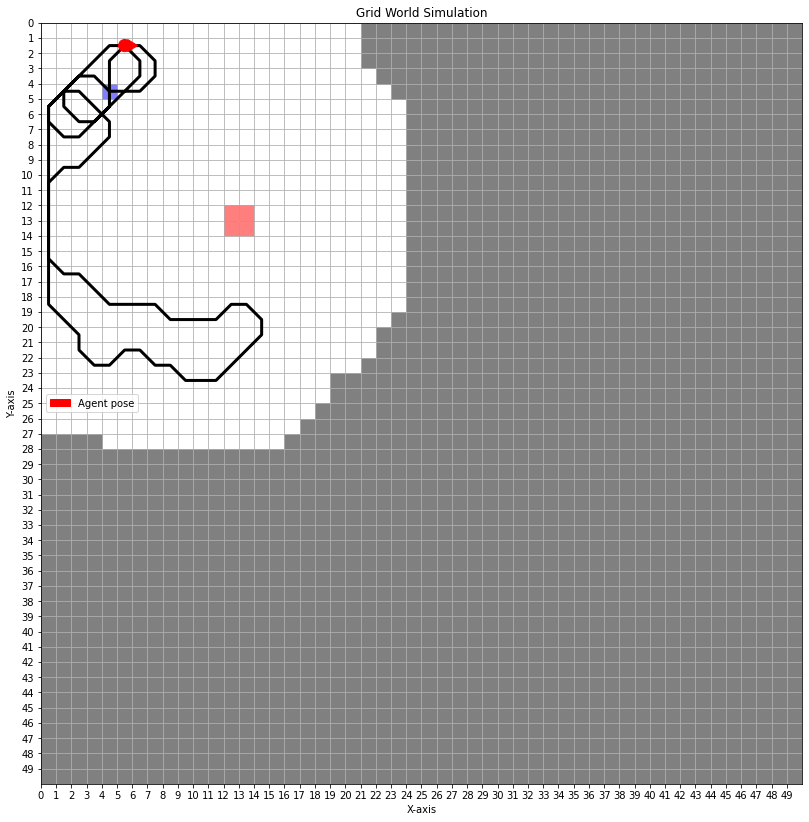

Iteration 1010
Iteration 1020
Iteration 1030
Iteration 1040
Iteration 1050
Iteration 1060
Iteration 1070
Iteration 1080
Iteration 1090
Iteration 1100
Iteration 1110
Iteration 1120
Iteration 1130
Iteration 1140
Iteration 1150
Iteration 1160
Iteration 1170
Iteration 1180
Iteration 1190
Iteration 1200
Iteration 1210
Iteration 1220
Iteration 1230
Iteration 1240
Iteration 1250
Iteration 1260
Iteration 1270
Iteration 1280
Iteration 1290
Iteration 1300
Iteration 1310
Iteration 1320
Iteration 1330
Iteration 1340
Iteration 1350
Iteration 1360
Iteration 1370
Iteration 1380
Iteration 1390
Iteration 1400
Iteration 1410
Iteration 1420
Iteration 1430
Iteration 1440
Iteration 1450
Iteration 1460
Iteration 1470
Iteration 1480
Iteration 1490
Iteration 1500
Iteration 1510
Iteration 1520
Iteration 1530
Iteration 1540
Iteration 1550
Iteration 1560
Iteration 1570
Iteration 1580
Iteration 1590
Iteration 1600
Iteration 1610
Iteration 1620
Iteration 1630
Iteration 1640
Iteration 1650
Iteration 1660
Iteration 

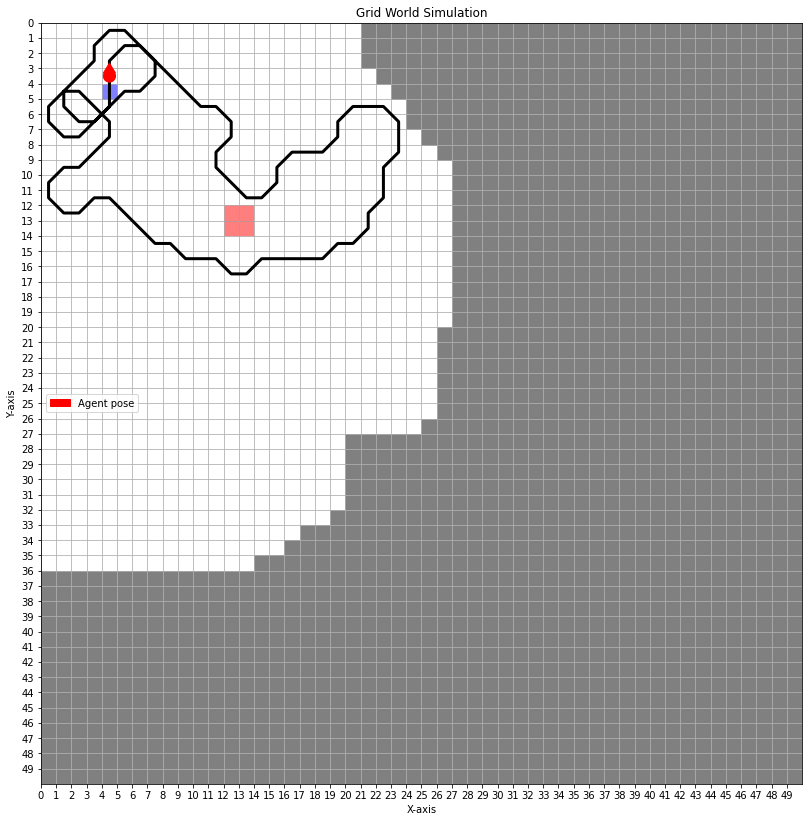

Iteration 2010
Iteration 2020
Iteration 2030
Iteration 2040
Iteration 2050
Iteration 2060
Iteration 2070
Iteration 2080
Iteration 2090
Iteration 2100
Iteration 2110
Iteration 2120
Iteration 2130
Iteration 2140
Iteration 2150
Iteration 2160
Iteration 2170
Iteration 2180
Iteration 2190
Iteration 2200
Iteration 2210
Iteration 2220
Iteration 2230
Iteration 2240
Iteration 2250
Iteration 2260
Iteration 2270
Iteration 2280
Iteration 2290
Iteration 2300
Iteration 2310
Iteration 2320
Iteration 2330
Iteration 2340
Iteration 2350
Iteration 2360
Iteration 2370
Iteration 2380
Iteration 2390
Iteration 2400
Iteration 2410
Iteration 2420
Iteration 2430
Iteration 2440
Iteration 2450
Iteration 2460
Iteration 2470
Iteration 2480
Iteration 2490
Iteration 2500
Iteration 2510
Iteration 2520
Iteration 2530
Iteration 2540
Iteration 2550
Iteration 2560
Iteration 2570
Iteration 2580
Iteration 2590
Iteration 2600
Iteration 2610
Iteration 2620
Iteration 2630
Iteration 2640
Iteration 2650
Iteration 2660
Iteration 

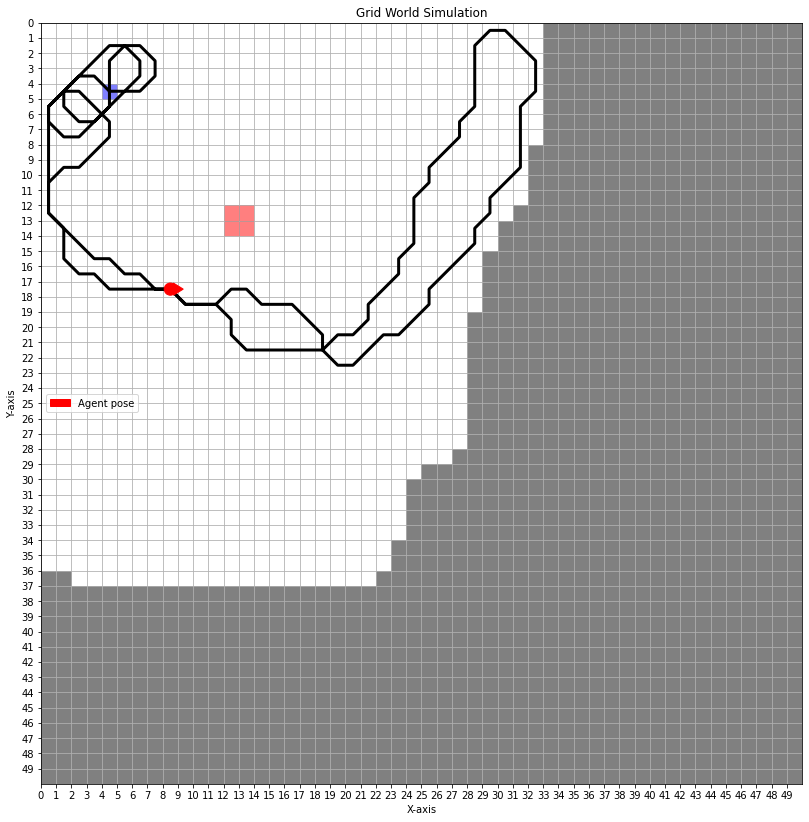

Iteration 3010
Iteration 3020
Iteration 3030
Iteration 3040
Iteration 3050
Iteration 3060
Iteration 3070
Iteration 3080
Iteration 3090
Iteration 3100
Iteration 3110
Iteration 3120
Iteration 3130
Iteration 3140
Iteration 3150
Iteration 3160
Iteration 3170
Iteration 3180
Iteration 3190
Iteration 3200
Iteration 3210
Iteration 3220
Iteration 3230
Iteration 3240
Iteration 3250
Iteration 3260
Iteration 3270
Iteration 3280
Iteration 3290
Iteration 3300
Iteration 3310
Iteration 3320
Iteration 3330
Iteration 3340
Iteration 3350
Iteration 3360
Iteration 3370
Iteration 3380
Iteration 3390
Iteration 3400
Iteration 3410
Iteration 3420
Iteration 3430
Iteration 3440
Iteration 3450
Iteration 3460
Iteration 3470
Iteration 3480
Iteration 3490
Iteration 3500
Iteration 3510
Iteration 3520
Iteration 3530
Iteration 3540
Iteration 3550
Iteration 3560
Iteration 3570
Iteration 3580
Iteration 3590
Iteration 3600
Iteration 3610
Iteration 3620
Iteration 3630
Iteration 3640
Iteration 3650
Iteration 3660
Iteration 

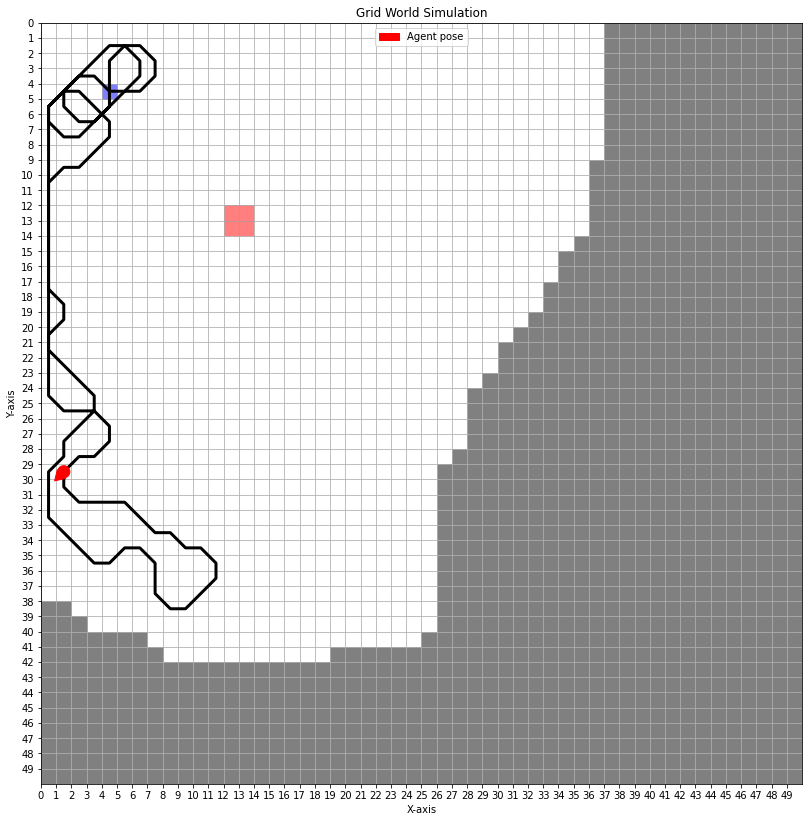

Iteration 4010
Iteration 4020
Iteration 4030
Iteration 4040
Iteration 4050
Iteration 4060
Iteration 4070
Iteration 4080
Iteration 4090
Iteration 4100
Iteration 4110
Iteration 4120
Iteration 4130
Iteration 4140
Iteration 4150
Iteration 4160
Iteration 4170
Iteration 4180
Iteration 4190
Iteration 4200
Iteration 4210
Iteration 4220
Iteration 4230
Iteration 4240
Iteration 4250
Iteration 4260
Iteration 4270
Iteration 4280
Iteration 4290
Iteration 4300
Iteration 4310
Iteration 4320
Iteration 4330
Iteration 4340
Iteration 4350
Iteration 4360
Iteration 4370
Iteration 4380
Iteration 4390
Iteration 4400
Iteration 4410
Iteration 4420
Iteration 4430
Iteration 4440
Iteration 4450
Iteration 4460
Iteration 4470
Iteration 4480
Iteration 4490
Iteration 4500
Iteration 4510
Iteration 4520
Iteration 4530
Iteration 4540
Iteration 4550
Iteration 4560
Iteration 4570
Iteration 4580
Iteration 4590
Iteration 4600
Iteration 4610
Iteration 4620
Iteration 4630
Iteration 4640
Iteration 4650
Iteration 4660
Iteration 

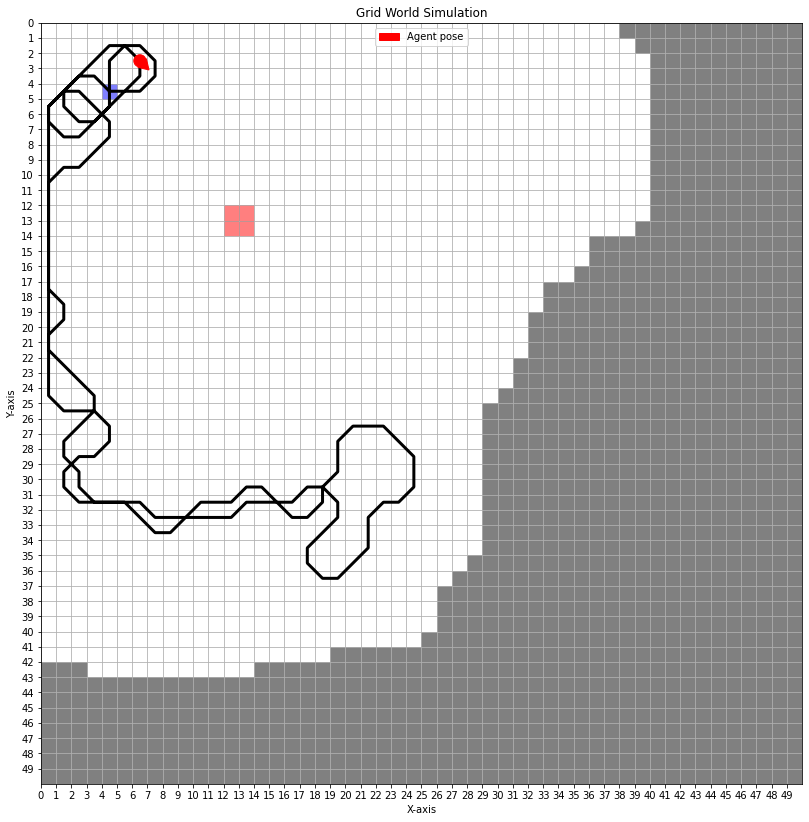

Iteration 5010
Iteration 5020
Iteration 5030
Iteration 5040
Iteration 5050
Iteration 5060
Iteration 5070
Iteration 5080
Iteration 5090
Iteration 5100
Iteration 5110
Iteration 5120
Iteration 5130
Iteration 5140
Iteration 5150
Iteration 5160
Iteration 5170
Iteration 5180
Iteration 5190
Iteration 5200
Iteration 5210
Iteration 5220
Iteration 5230
Iteration 5240
Iteration 5250
Iteration 5260
Iteration 5270
Iteration 5280
Iteration 5290
Iteration 5300
Iteration 5310
Iteration 5320
Iteration 5330
Iteration 5340
Iteration 5350
Iteration 5360
Iteration 5370
Iteration 5380
Iteration 5390
Iteration 5400
Iteration 5410
Iteration 5420
Iteration 5430
Iteration 5440
Iteration 5450
Iteration 5460
Iteration 5470
Iteration 5480
Iteration 5490
Iteration 5500
Iteration 5510
Iteration 5520
Iteration 5530
Iteration 5540
Iteration 5550
Iteration 5560
Iteration 5570
Iteration 5580
Iteration 5590
Iteration 5600
Iteration 5610
Iteration 5620
Iteration 5630
Iteration 5640
Iteration 5650
Iteration 5660
Iteration 

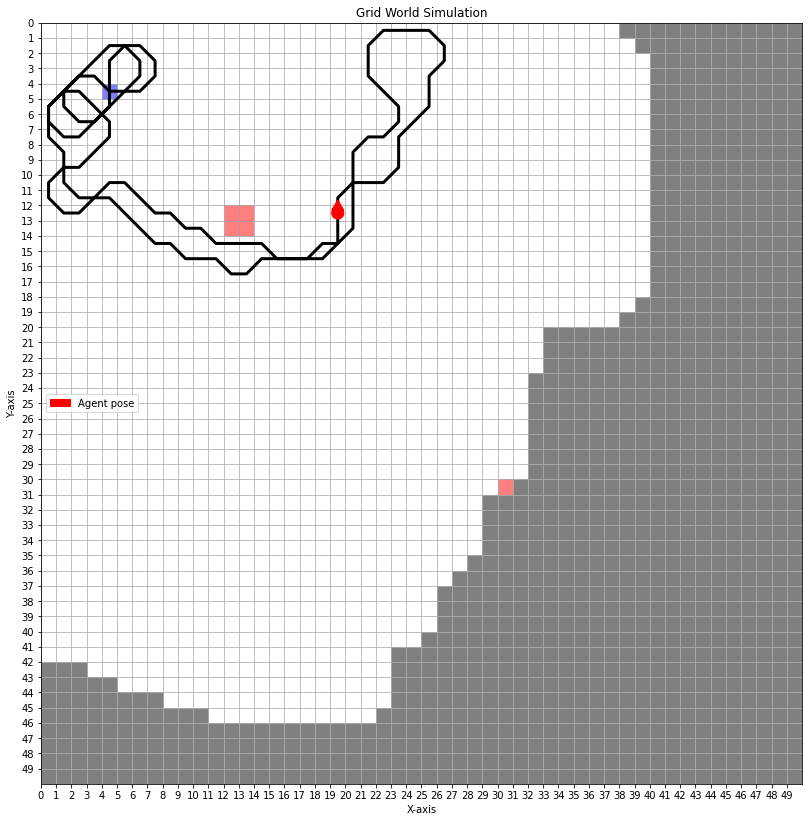

Iteration 6010
Iteration 6020
Iteration 6030
Iteration 6040
Iteration 6050
Iteration 6060
Iteration 6070
Iteration 6080
Iteration 6090
Iteration 6100
Iteration 6110
Iteration 6120
Iteration 6130
Iteration 6140
Iteration 6150
Iteration 6160
Iteration 6170
Iteration 6180
Iteration 6190
Iteration 6200
Iteration 6210
Iteration 6220
Iteration 6230
Iteration 6240
Iteration 6250
Iteration 6260
Iteration 6270
Iteration 6280
Iteration 6290
Iteration 6300
Iteration 6310
Iteration 6320
Iteration 6330
Iteration 6340
Iteration 6350
Iteration 6360
Iteration 6370
Iteration 6380
Iteration 6390
Iteration 6400
Iteration 6410
Iteration 6420
Iteration 6430
Iteration 6440
Iteration 6450
Iteration 6460
Iteration 6470
Iteration 6480
Iteration 6490
Iteration 6500
Iteration 6510
Iteration 6520
Iteration 6530
Iteration 6540
Iteration 6550
Iteration 6560
Iteration 6570
Iteration 6580
Iteration 6590
Iteration 6600
Iteration 6610
Iteration 6620
Iteration 6630
Iteration 6640
Iteration 6650
Iteration 6660
Iteration 

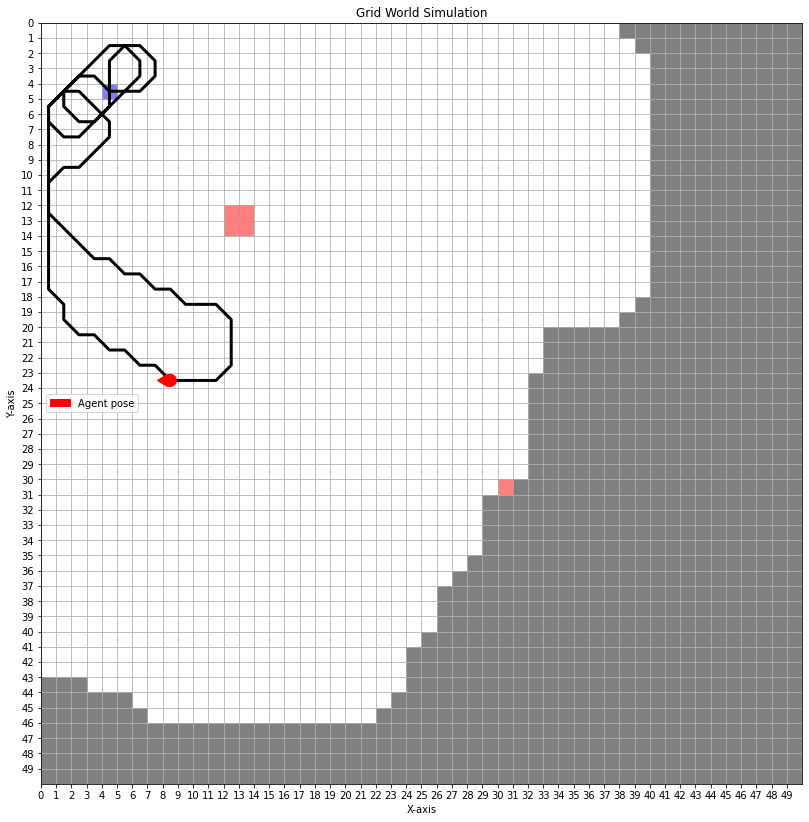

Iteration 7010
Iteration 7020
Iteration 7030
Iteration 7040
Iteration 7050
Iteration 7060
Iteration 7070
Iteration 7080
Iteration 7090
Iteration 7100
Iteration 7110
Iteration 7120
Iteration 7130
Iteration 7140
Iteration 7150
Iteration 7160
Iteration 7170
Iteration 7180
Iteration 7190
Iteration 7200
Iteration 7210
Iteration 7220
Iteration 7230
Iteration 7240
Iteration 7250
Iteration 7260
Iteration 7270
Iteration 7280
Iteration 7290
Iteration 7300
Iteration 7310
Iteration 7320
Iteration 7330
Iteration 7340
Iteration 7350
Iteration 7360
Iteration 7370
Iteration 7380
Iteration 7390
Iteration 7400
Iteration 7410
Iteration 7420
Iteration 7430
Iteration 7440
Iteration 7450
Iteration 7460
Iteration 7470
Iteration 7480
Iteration 7490
Iteration 7500
Iteration 7510
Iteration 7520
Iteration 7530
Iteration 7540
Iteration 7550
Iteration 7560
Iteration 7570
Iteration 7580
Iteration 7590
Iteration 7600
Iteration 7610
Iteration 7620
Iteration 7630
Iteration 7640
Iteration 7650
Iteration 7660
Iteration 

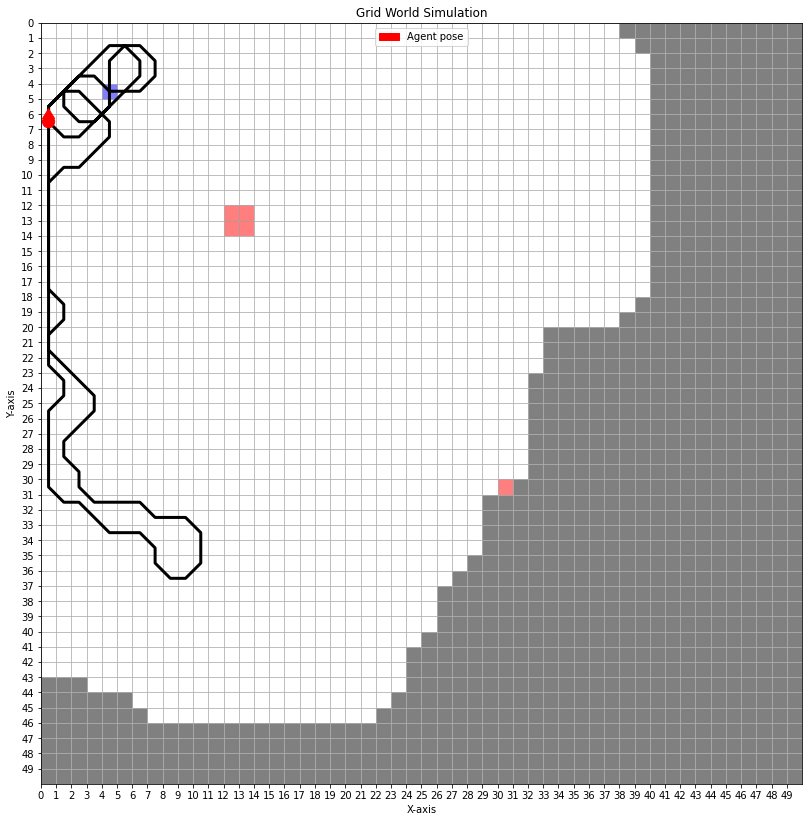

Iteration 8010
Iteration 8020
Iteration 8030
Iteration 8040
Iteration 8050
Iteration 8060
Iteration 8070
Iteration 8080
Iteration 8090
Iteration 8100
Iteration 8110
Iteration 8120
Iteration 8130
Iteration 8140
Iteration 8150
Iteration 8160
Iteration 8170
Iteration 8180
Iteration 8190
Iteration 8200
Iteration 8210
Iteration 8220
Iteration 8230
Iteration 8240
Iteration 8250
Iteration 8260
Iteration 8270
Iteration 8280
Iteration 8290
Iteration 8300
Iteration 8310
Iteration 8320
Iteration 8330
Iteration 8340
Iteration 8350
Iteration 8360
Iteration 8370
Iteration 8380
Iteration 8390
Iteration 8400
Iteration 8410
Iteration 8420
Iteration 8430
Iteration 8440
Iteration 8450
Iteration 8460
Iteration 8470
Iteration 8480
Iteration 8490
Iteration 8500
Iteration 8510
Iteration 8520
Iteration 8530
Iteration 8540
Iteration 8550
Iteration 8560
Iteration 8570
Iteration 8580
Iteration 8590
Iteration 8600
Iteration 8610
Iteration 8620
Iteration 8630
Iteration 8640
Iteration 8650
Iteration 8660
Iteration 

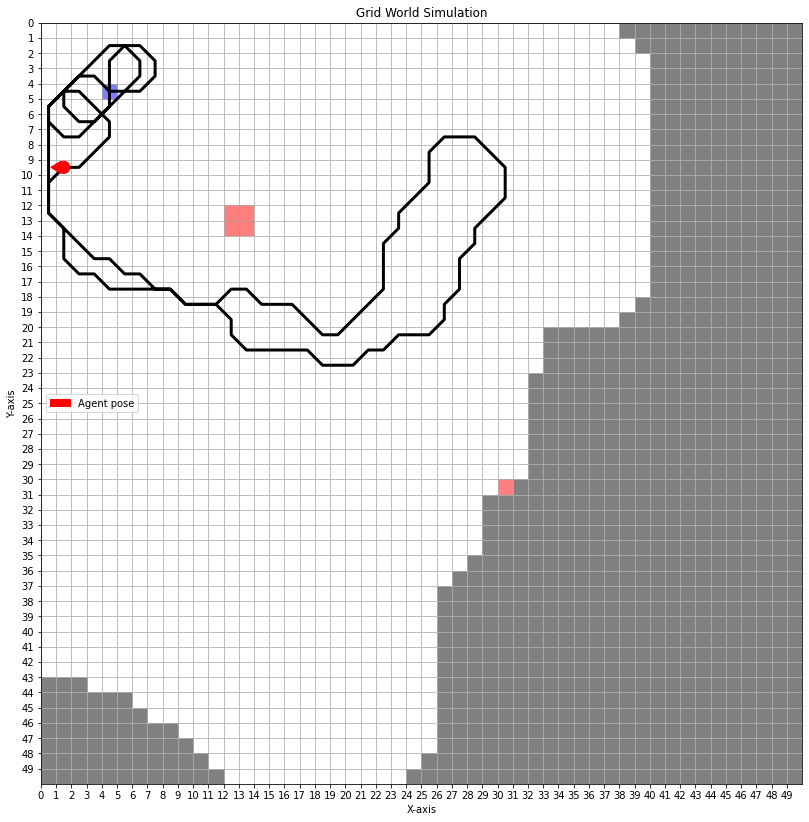

Iteration 9010
Iteration 9020
Iteration 9030
Iteration 9040
Iteration 9050
Iteration 9060
Iteration 9070
Iteration 9080
Iteration 9090
Iteration 9100
Iteration 9110
Iteration 9120
Iteration 9130
Iteration 9140
Iteration 9150
Iteration 9160
Iteration 9170
Iteration 9180
Iteration 9190
Iteration 9200
Iteration 9210
Iteration 9220
Iteration 9230
Iteration 9240
Iteration 9250
Iteration 9260
Iteration 9270
Iteration 9280
Iteration 9290
Iteration 9300
Iteration 9310
Iteration 9320
Iteration 9330
Iteration 9340
Iteration 9350
Iteration 9360
Iteration 9370
Iteration 9380
Iteration 9390
Iteration 9400
Iteration 9410
Iteration 9420
Iteration 9430
Iteration 9440
Iteration 9450
Iteration 9460
Iteration 9470
Iteration 9480
Iteration 9490
Iteration 9500
Iteration 9510
Iteration 9520
Iteration 9530
Iteration 9540
Iteration 9550
Iteration 9560
Iteration 9570
Iteration 9580
Iteration 9590
Iteration 9600
Iteration 9610
Iteration 9620
Iteration 9630
Iteration 9640
Iteration 9650
Iteration 9660
Iteration 

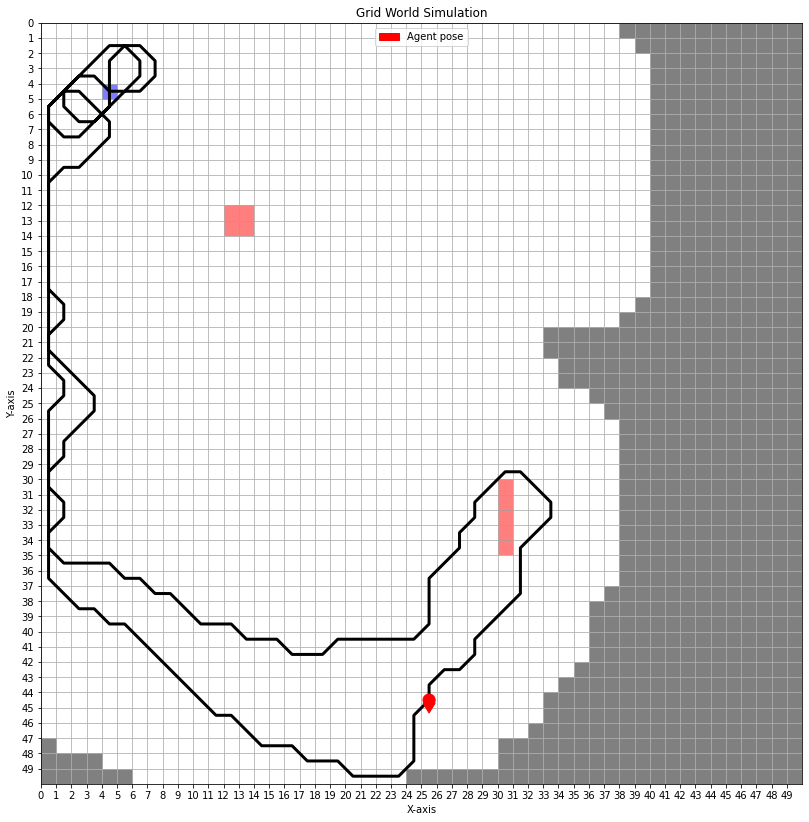

Iteration 10010
Iteration 10020
Iteration 10030
Iteration 10040
Iteration 10050
Iteration 10060
Iteration 10070
Iteration 10080
Iteration 10090
Iteration 10100
Iteration 10110
Iteration 10120
Iteration 10130
Iteration 10140
Iteration 10150
Iteration 10160
Iteration 10170
Iteration 10180
Iteration 10190
Iteration 10200
Iteration 10210
Iteration 10220
Iteration 10230
Iteration 10240
Iteration 10250
Iteration 10260
Iteration 10270
Iteration 10280
Iteration 10290
Iteration 10300
Iteration 10310
Iteration 10320
Iteration 10330
Iteration 10340
Iteration 10350
Iteration 10360
Iteration 10370
Iteration 10380
Iteration 10390
Iteration 10400
Iteration 10410
Iteration 10420
Iteration 10430
Iteration 10440
Iteration 10450
Iteration 10460
Iteration 10470
Iteration 10480
Iteration 10490
Iteration 10500
Iteration 10510
Iteration 10520
Iteration 10530
Iteration 10540
Iteration 10550
Iteration 10560
Iteration 10570
Iteration 10580
Iteration 10590
Iteration 10600
Iteration 10610
Iteration 10620
Iteratio

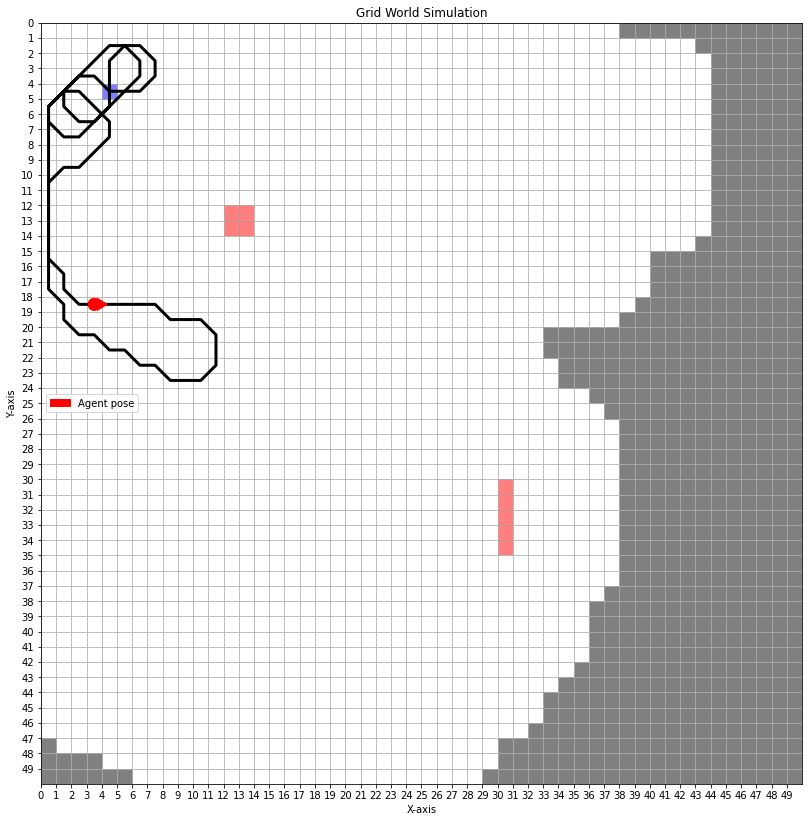

Iteration 11010
Iteration 11020
Iteration 11030
Iteration 11040
Iteration 11050
Iteration 11060
Iteration 11070
Iteration 11080
Iteration 11090
Iteration 11100
Iteration 11110
Iteration 11120
Iteration 11130
Iteration 11140
Iteration 11150
Iteration 11160
Iteration 11170
Iteration 11180
Iteration 11190
Iteration 11200
Iteration 11210
Iteration 11220
Iteration 11230
Iteration 11240
Iteration 11250
Iteration 11260
Iteration 11270
Iteration 11280
Iteration 11290
Iteration 11300
Iteration 11310
Iteration 11320
Iteration 11330
Iteration 11340
Iteration 11350
Iteration 11360
Iteration 11370
Iteration 11380
Iteration 11390
Iteration 11400
Iteration 11410
Iteration 11420
Iteration 11430
Iteration 11440
Iteration 11450
Iteration 11460
Iteration 11470
Iteration 11480
Iteration 11490
Iteration 11500
Iteration 11510
Iteration 11520
Iteration 11530
Iteration 11540
Iteration 11550
Iteration 11560
Iteration 11570
Iteration 11580
Iteration 11590
Iteration 11600
Iteration 11610
Iteration 11620
Iteratio

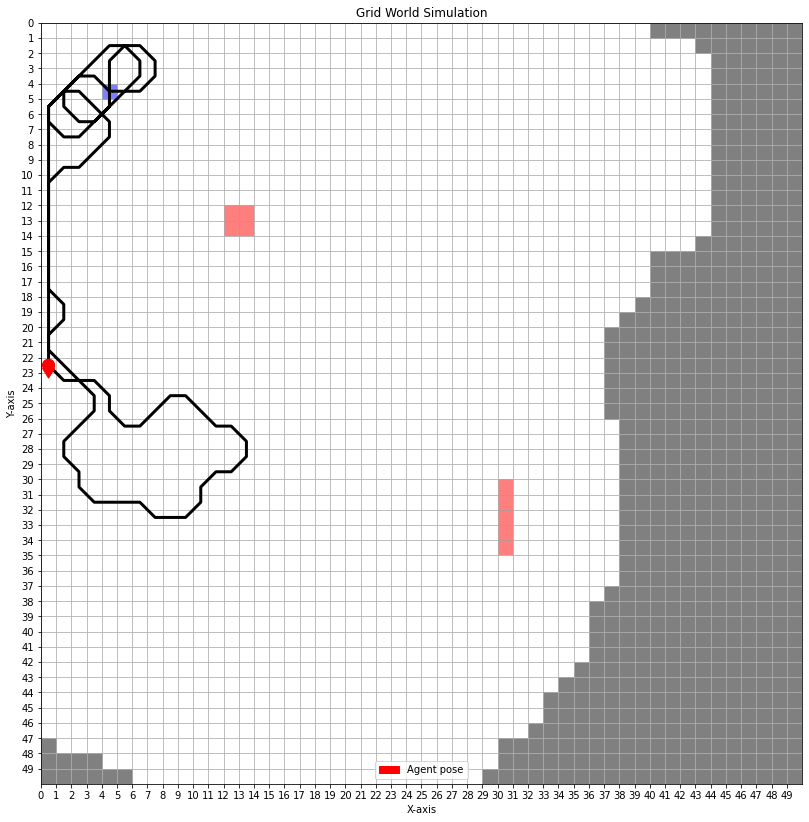

Iteration 12010
Iteration 12020
Iteration 12030
Iteration 12040
Iteration 12050
Iteration 12060
Iteration 12070
Iteration 12080
Iteration 12090
Iteration 12100
Iteration 12110
Iteration 12120
Iteration 12130
Iteration 12140
Iteration 12150
Iteration 12160
Iteration 12170
Iteration 12180
Iteration 12190
Iteration 12200
Iteration 12210
Iteration 12220
Iteration 12230
Iteration 12240
Iteration 12250
Iteration 12260
Iteration 12270
Iteration 12280
Iteration 12290
Iteration 12300
Iteration 12310
Iteration 12320
Iteration 12330
Iteration 12340
Iteration 12350
Iteration 12360
Iteration 12370
Iteration 12380
Iteration 12390
Iteration 12400
Iteration 12410
Iteration 12420
Iteration 12430
Iteration 12440
Iteration 12450
Iteration 12460
Iteration 12470
Iteration 12480
Iteration 12490
Iteration 12500
Iteration 12510
Iteration 12520
Iteration 12530
Iteration 12540
Iteration 12550
Iteration 12560
Iteration 12570
Iteration 12580
Iteration 12590
Iteration 12600
Iteration 12610
Iteration 12620
Iteratio

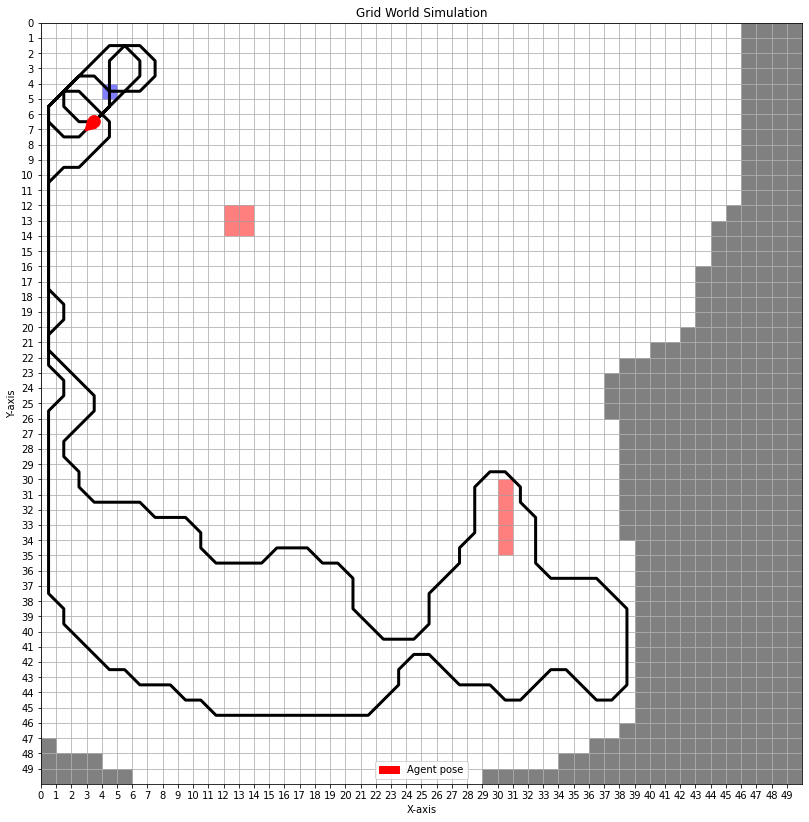

Iteration 13010
Iteration 13020
Iteration 13030
Iteration 13040
Iteration 13050
Iteration 13060
Iteration 13070
Iteration 13080
Iteration 13090
Iteration 13100
Iteration 13110
Iteration 13120
Iteration 13130
Iteration 13140
Iteration 13150
Iteration 13160
Iteration 13170
Iteration 13180
Iteration 13190
Iteration 13200
Iteration 13210
Iteration 13220
Iteration 13230
Iteration 13240
Iteration 13250
Iteration 13260
Goal reached, iteration: 13269
agent_trajectory: 
[(4, 4), (4, 3), (4, 2), (5, 1), (6, 1), (7, 2), (7, 3), (6, 4), (5, 4), (4, 5), (3, 6), (2, 7), (1, 7), (0, 6), (0, 5), (1, 4), (2, 4), (3, 5), (4, 6), (4, 7), (3, 8), (2, 9), (1, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (1, 23), (1, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (1, 38), (1, 39), (2, 40), (3, 41), (4, 42), (5, 42), (6, 43), (7, 43), (8, 43), (9, 44), (10, 44

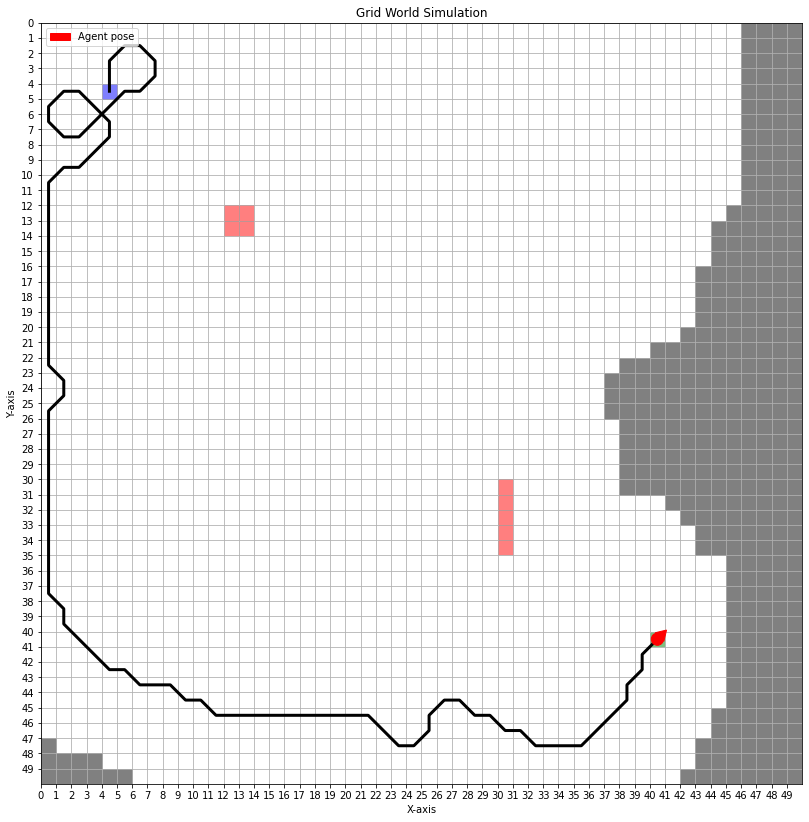

In [101]:
# SIMULATION
grid_height = 50
grid_width = 50
grid_2d = np.zeros((grid_height, grid_width))

# obstacles
# grid_2d[12:14, 12:14] = 1
obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
for obstacle in obstacles:
    grid_2d[obstacle[1], obstacle[0]] = 1

start_tyx = (0, 4, 4)
goal_tyx = (1,40,40)
grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# MEDIUM simulation
# grid_height = 25
# grid_width = 25
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (1,20,20)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# SMALL simulation
# grid_height = 12
# grid_width = 12
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# # grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (3,11,11)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
for i in range(grid_height):
    for j in range(grid_width):
        for k in range(8):
            world_table[k, i, j] = Node(k, i, j)

home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
home.in_gf = True
home.in_gb = True
goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
goal.in_gb = True


agent = Agent(home, goal, world_table)



iteration = 0
max_iterations = 20000
while iteration < max_iterations:
    if iteration % 10 == 0:
        print(f'Iteration {iteration}')
        # print(f'Visible: \n{str(agent.visible_positions)}')
        # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
        # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
        # print(f'agent_trajectory: \n{agent.trajectory}')

    if iteration % 1000 == 0:
        agent.plot_iteration()

    # sample a point to add to GF
    for _ in range(20):
        # success = False
        # while not success:
        coord = agent.sample_for_gf()
        # coord = (0, 8, 10)
        if coord is not None:
            success = agent.attempt_add_node_to_gf(coord)

    # sample a point to add to GB
    i = 0
    while i < 20 or len(agent.unvisited_gb) <= 0:
        i += 1
        coord, index = agent.sample_for_gb()
        if coord is None:
            continue
        success = agent.attempt_add_node_to_gb(coord, index)
        # if success: print(f'Added to GB: {coord}')

    if not agent.move(grid_2d):
        print(f'Failed to move, iteration: {iteration}')
        break

    # assert agent.pose not in obstacles, 'Agent ran into obstacle :('
    if agent.pose in obstacles:
        print(f'Agent ran into obstacle, iteration: {iteration}')
        print(f'Pose: {agent.pose}')
        agent.plot_iteration()
        break



    if agent.pose == (goal.x, goal.y):
        print(f'Goal reached, iteration: {iteration}')
        print(f'agent_trajectory: \n{agent.trajectory}')
        break

    iteration += 1
    # time.sleep(0.01)
if iteration == max_iterations:
    print('Max iterations reached :(')
print(f'DONE: Iteration: {iteration}')
agent.plot_iteration()
